In [1]:
import tomosipo as ts
import numpy as np
import pickle
import mrcfile
import numpy as np
from scipy.ndimage import zoom
from sklearn.manifold import TSNE
from sklearn.manifold import TSNE
from numpy import reshape
import seaborn as sns
import pandas as pd  
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import v_measure_score
import os
%matplotlib inline


In [2]:
vg = ts.volume(shape=(32, 32, 32), size=(1, 1, 1))
pg = ts.parallel(angles=32, shape=(48, 48), size=(1.5, 1.5))

In [3]:
svg = ts.svg(vg, pg)
svg.save("./doc/img/intro_forward_projection_geometries.svg")

In [4]:
A = ts.operator(vg, pg)


In [5]:
x = np.ones(A.domain_shape, dtype=np.float32)

In [6]:
y = A(x)

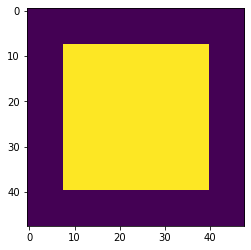

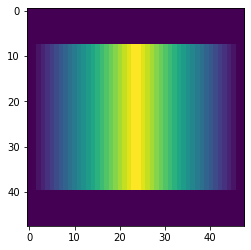

In [7]:
import matplotlib.pyplot as plt
plt.imshow(y[:, 0, :]) # first projection
plt.show()
plt.imshow(y[:, 8, :]) # quarter rotation
plt.show()

In [8]:
"""
Load 3DVA angles
"""
f = open('./data/angles_3DVA.txt')
text = []
for line in f:
    floats_list = [float(item) for item in line.split()]

    text.append(floats_list[:3])
angles = np.array(text)
print(np.max(angles[:, 0]))
print(np.max(angles[:, 1]))
print(np.max(angles[:, 2]))
angles[:, 0] = angles[:, 0] / 360 * 2 *np.pi
angles[:, 1] = angles[:, 0] / 360 * 1 *np.pi
angles[:, 2] = angles[:, 0] / 360 * 2 *np.pi

print(angles[:5])
print(angles.shape)
angles2 = angles

359.95001
178.00002
359.95105
[[2.28411239 0.01993264 0.03986528]
 [2.05058716 0.01789475 0.0357895 ]
 [6.10777989 0.05330043 0.10660087]
 [0.75984672 0.00663091 0.01326183]
 [5.85749933 0.05111632 0.10223265]]
(9453, 3)


In [9]:
"""
Load 3DVA order
"""
f = open('./data/70S_5class_simu_labels.txt')
text = []
for line in f:
    intlist = [int(item) for item in line.split()]

    text.append(intlist[0])
print(text[:5])
S_count = []
for i in range(5):
    S_count.append( text.count(i))
    print(i, text.count(i))
Index_3DVA = text
#You can see that the mean structure is 

[3, 0, 2, 0, 2]
0 2804
1 1904
2 1911
3 1417
4 1417


In [10]:
with open('./data/3DVA_images_22.pkl', 'rb') as f:
    new_projection = pickle.load(f)

(9453, 34, 34)


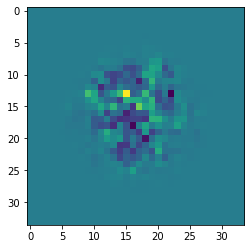

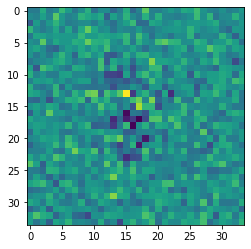

In [11]:
#Add noise 
print(new_projection.shape)
plt.imshow(new_projection[0])
plt.show()
sn_ratio = 0.5
num_imgs = new_projection.shape[0]
img_size = new_projection.shape[-1]


noise_var = new_projection.var()/sn_ratio
new_projection = new_projection + np.sqrt(noise_var)*np.random.randn(num_imgs, img_size, img_size)
plt.imshow(new_projection[0])
plt.show()

In [12]:
import astra
ProjSize = 34
with open('./data/3DVA_Orientation_Vectors.pkl', 'rb') as handle:
    Orientation_Vectors = pickle.load(handle  )
Orientation_Vectors = Orientation_Vectors
print(Orientation_Vectors.shape)
Proj_geom = astra.create_proj_geom('parallel3d_vec', ProjSize, ProjSize, Orientation_Vectors)
print(Orientation_Vectors.shape)

(9453, 12)
(9453, 12)


In [13]:
from tomosipo.geometry.parallel_vec import *
#pg = ParallelVectorGeometry.from_astra(Proj_geom)
pg = ts.from_astra(Proj_geom)

In [14]:
#vg = ts.volume(shape=(32, 32, 32), size=(1, 1, 1))
#pg = ts.parallel(angles=50, shape=(48, 48), size=(1.5, 1.5))
Proj_geom = astra.create_proj_geom('parallel3d_vec', ProjSize, ProjSize, Orientation_Vectors)
Vol_geom = astra.create_vol_geom(34, 34, 34)
vg = ts.from_astra(Vol_geom)
pg = ts.from_astra(Proj_geom)
A = ts.operator(vg, pg)
from scipy.ndimage import zoom


In [15]:
print(pg.ray_dir[:5])
print(pg.det_v[:5])
print(pg.det_u[:5])


[[ 9.99801351e-01  7.94357283e-04 -1.99154852e-02]
 [ 9.99839893e-01  6.40273182e-04 -1.78823350e-02]
 [ 9.98579868e-01  5.66843270e-03 -5.29727846e-02]
 [ 9.99978016e-01  8.79348061e-05 -6.63028183e-03]
 [ 9.98693845e-01  5.21438774e-03 -5.08272947e-02]]
[[ 0.01507199 -0.68395708  0.72936654]
 [ 0.01587343 -0.49303474  0.8698648 ]
 [-0.00929691  0.99760753 -0.06850385]
 [ 0.00456741  0.71574344  0.69834839]
 [-0.02109907  0.94808841 -0.31730615]]
[[-0.01304196 -0.72952182 -0.68383318]
 [-0.00825966 -0.87000939 -0.49296597]
 [ 0.05245774  0.06889905  0.9962435 ]
 [ 0.00480699 -0.69836332  0.7157273 ]
 [ 0.04653421  0.3179641   0.94696008]]


In [16]:
print(Orientation_Vectors[:5])
print(pg[:5])

[[-1.99154852e-02  7.94357283e-04  9.99801351e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -6.83833182e-01 -7.29521821e-01
  -1.30419594e-02  7.29366543e-01 -6.83957076e-01  1.50719889e-02]
 [-1.78823350e-02  6.40273182e-04  9.99839893e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -4.92965970e-01 -8.70009385e-01
  -8.25966138e-03  8.69864802e-01 -4.93034745e-01  1.58734322e-02]
 [-5.29727846e-02  5.66843270e-03  9.98579868e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  9.96243497e-01  6.88990537e-02
   5.24577394e-02 -6.85038548e-02  9.97607533e-01 -9.29691395e-03]
 [-6.63028183e-03  8.79348061e-05  9.99978016e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  7.15727301e-01 -6.98363318e-01
   4.80698984e-03  6.98348387e-01  7.15743438e-01  4.56740827e-03]
 [-5.08272947e-02  5.21438774e-03  9.98693845e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  9.46960081e-01  3.17964104e-01
   4.65342118e-02 -3.17306147e-01  9.48088413e-01 -2.10990723e-02]]
ts.p

In [17]:
from tomosipo.torch_support import to_autograd
import time
"""
First step. write out the
1. Expectation
2. likelihood
Then use .backward solve it


For AU with U with batch n^3, to_autograd take batch input, which is actually what I want!!!!, so no need for one by one concatenate!!!

"""
def reshape_fortran(x, shape):
    if len(x.shape) > 0:
        x = x.permute(*reversed(range(len(x.shape))))
    return x.reshape(*reversed(shape)).permute(*reversed(range(len(shape))))
def Trace_bradcast(a):
    b = torch.einsum('bii->b', a)
    return b
import torch


class MPCA_3d_recon():
    def __init__(self, ProjSize, num_image, n_component, op, Images, exp_name, batch_size = 1000, n_iter = 20):
        #init
        self.exp_name = exp_name
        self.ProjSize  = ProjSize
        self.z_size = n_component # First set 1 for simplicity
        self.num_image = num_image
        self.n_component = n_component
        self.batch_size = batch_size
        self.n_iter = n_iter
        
        """
        projection operator and images
        """
        self.op = to_autograd(op)
        Images = torch.tensor(Images)
        self.All_Image = Images
        self.I = reshape_fortran(Images, (self.num_image, self.ProjSize*self.ProjSize , 1)).float() # N x D^2 x 1
        self.All_I = self.I
        """
        paramters we want to find
        """
        self.U1 = torch.eye(self.ProjSize)[:, :self.z_size] +1
        self.U2 = torch.eye(self.ProjSize)[:, :self.z_size] +1 
        self.U3 = torch.eye(self.ProjSize)[:, :self.z_size] +1
        #print('self.U1',self.U1.shape)
        self.U1.data = torch.qr(self.U1.data)[0]
        self.U2.data = torch.qr(self.U2.data)[0]
        self.U3.data = torch.qr(self.U3.data)[0]
        #print('ortho_U1',ortho_U1.shape)
        #print(ortho_U1.T@ortho_U1)
        
        self.U1.requires_grad =True
        self.U2.requires_grad =True
        self.U3.requires_grad =True
        self.All_U = torch.kron(self.U1, torch.kron(self.U2, self.U3))
        self.Sigma_Z_inv = torch.eye(self.n_component ** 3) # size: p1 x p2 x p3 
        self.sigma = torch.ones(self.batch_size).reshape(-1, 1 ,1) * 1
        #print('sigma monotoring',torch.mean(self.sigma))
        """
        Expectation term
        or so called missing data
        """
        self.mu = torch.abs(torch.ones((self.batch_size, n_component **3,1)))
        self.BigSigma_I = torch.abs(torch.ones((self.batch_size, self.n_component**3, self.n_component**3 )))

       

    def A_pro_All_U(self, detach_list = []):
        #print('in A por U')
        #self.All_U # shape = Ps ^3 x n  ^3: which we should make it Ps x Ps x Ps x n ^3 to process
        #A: Ps x Ps x Ps x 1 ->  Ps x Ps x 1
        
        #So overal, we have Mu = N x D^3 x n^3
        #AMu = N x D^2 x n^3
        """
        for i in range(self.n_component**3):
            Vol_i = self.All_U[:, i].reshape(self.ProjSize, self.ProjSize,self.ProjSize)
            Proj_i = self.op(Vol_i).permute(1, 0, 2)
            Proj_i = reshape_fortran(Proj_i, (self.num_image, self.ProjSize*self.ProjSize ,1))
            
            #print(Proj_i.shape)
            if i == 0:
                self.AU = Proj_i
            else:
                self.AU = torch.cat((self.AU, Proj_i), 2)
        #print('self.AU',self.AU.shape)
        
        #Broad cast: torch.matmul
        # (AU).T(AU) = torch.matmul(self.AU.permute(0,2,1), self.AU.permute(0,2,1))
        #torch.matmul(self.AU.permute(0,2,1), self.AU)
        """
        U1 , U2, U3 = self.U1, self.U2, self.U3
        if 1 in detach_list:
            U1 = U1.detach()
        if 2 in detach_list:
            U2 = U2.detach()
        if 3 in detach_list:
            U3 = U3.detach()
        
        
        self.All_U = torch.kron(U1, torch.kron(U2, U3))
        self.All_U = reshape_fortran(self.All_U, (self.ProjSize, self.ProjSize, self.ProjSize, self.n_component**3)) #D^3 x n^3 -> D xD x D x n^3
        self.All_U = self.All_U.permute(3, 0, 1, 2) # make it n x Dx Dx D
        #print(self.All_U.shape)
        self.AU = self.op( self.All_U) # n x Dx Dx D -> n x D x N x D
        #print('self.AU',self.AU.shape)
        self.AU = self.AU.permute(2, 0, 1, 3) # N x n x D x D
        #print( self.AU.permute(2, 0, 1, 3).shape)
        self.AU = reshape_fortran(self.AU, (self.batch_size, self.n_component**3, self.ProjSize**2))
        self.AU = self.AU.permute(0, 2, 1) # N x n x D x D
        
        #print('self.AU',self.AU.shape)
        
    def Expectation(self):
        #print('in Exp')
        
        """
        First, get all projection information
        
        ro_j = 1/sigma^2 * (Sigmz_Z_inv + 1/sigma^2 * (Au)^TAu)^(-1)(Au)^TI
        
        #We expect to get a n_image x n_component matrix for ro
        
        BigSigma = I - 1 / sigma^2 * (I + 1/sigma^2 * (Au)^TAu)^(-1) (Au)^TAu9htu
        
        Here, the shape of All_U is PS^3 x n_component^3, but A can only process a 3d volume PS^3 at once
        
        """
        #print(torch.unsqueeze(self.Sigma_Z_inv,0  ).shape)
        #print((1 / self.sigma **2).shape)
        
        UTATAU = torch.matmul(self.AU.permute(0,2,1), self.AU)
        #print(UTAAU.shape)
        #print((1 / self.sigma **2 * UTAAU ).shape)
        self.mu = torch.inverse(torch.unsqueeze(self.Sigma_Z_inv,0  ) + 1 / self.sigma **2 * UTATAU ) * 1 / self.sigma **2 
        self.mu = torch.matmul(self.mu , self.AU.permute(0,2,1))
        self.mu = torch.matmul(self.mu, self.I)
        #print('self.mu.shape',self.mu.shape)
        
        
        """
        So we found Mu
        Then we found Sigma_I
        torch.inverse can broadcast through batch, so just use it
        """
        self.BigSigma_I = torch.inverse((torch.unsqueeze(self.Sigma_Z_inv,0  ) + 1 / self.sigma **2 * UTATAU )) + torch.matmul(self.mu, self.mu.permute(0,2,1))
        #print('self.BigSigma_I', self.BigSigma_I.shape)
        self.mu = self.mu.detach()
        self.BigSigma_I = self.BigSigma_I.detach()
        #print('torch.mean(self.mu)', torch.mean(self.mu))
        #print('torch.mean(self.BigSigma_I)', torch.mean(self.BigSigma_I))
        
    def Q_Function(self, ):
        #print('in Q')
        """
        #left term
        #print('self.AU', torch.mean(self.AU))
        print('in Q')
        print('self.mu ', torch.mean(self.mu ))
        print('self.BigSigma_I', torch.mean(self.BigSigma_I))
        #print('self.sigma', torch.mean(self.sigma))
        print('self.Sigma_Z_inv',torch.mean(self.Sigma_Z_inv))
        print('self.U1', torch.mean(self.U1))
        print('self.U2', torch.mean(self.U2))
        print('self.U3', torch.mean(self.U3))
        
        try:
            print('self.U1.grad.data',torch.mean(self.U1.grad.data))
            print('self.U2.grad.data',torch.mean(self.U2.grad.data))
            print('self.U3.grad.data',torch.mean(self.U3.grad.data))
        
        except:
            pass
        """
        
        left = -2 * self.I.permute(0, 2, 1) @ self.AU @ self.mu 
        #UTATAU = torch.matmul(self.AU.permute(0,2,1), self.AU)
        #print('self.AU', self.AU.shape)
        #print('self.BigSigma_I', self.BigSigma_I.shape)
        #print('self.AU.permute(0,2,1)', self.AU.permute(0,2,1).shape)
        left = left + Trace_bradcast(self.AU @ self.BigSigma_I @ self.AU.permute(0,2,1))   #self.mu.permute(0, 2, 1) @  UTATAU @ self.mu
        left = 1 / self.sigma **2 *left
        
        #middle term
        #print('self.mu', self.mu.shape)
        #print('torch.unsqueeze(self.Sigma_Z_inv,0  )', torch.unsqueeze(self.Sigma_Z_inv,0  ).shape)
        #middle = self.mu.permute(0, 2, 1)  @torch.unsqueeze(self.Sigma_Z_inv,0  ) @self.mu
        middle = Trace_bradcast( torch.unsqueeze(self.Sigma_Z_inv,0  ) @ self.BigSigma_I )
        
        
        right = torch.log(torch.det(torch.inverse(self.Sigma_Z_inv)))
        self.Q = -1/2 * torch.sum(left + middle + right)/100000000
        #print('self.Q',self.Q.shape,self.Q)
        #print(self.Q)
    def Maximization(self, ratio):
        #print('in max')
        """
        Update U1, U2, U3 by gradient assent and use svd to make sure orthogonality
        self.U1.grad.data.zero_() # conduct zero grad
        self.Q.backward()
        
        """
        self.Sigma_Z_inv = torch.inverse(torch.mean(self.BigSigma_I, 0)).detach()
        #print('self.Sigma_Z_inv ', torch.mean(self.Sigma_Z_inv ))
        
        start = time.time()
        
        self.A_pro_All_U([2,3])
        self.Q_Function()
        #print('q fun ction time', time.time()- start)
        self.Q.backward()
        #print('backward time', time.time()- start)
        
        lr = torch.mean(torch.abs(self.U1)) /  torch.mean(torch.abs(self.U1.grad)) * ratio# 0.01
        #print('torch.mean(torch.abs(self.U1.grad))', torch.mean(torch.abs(self.U1.grad)))
        self.U1.data +=  lr * self.U1.grad.data
        self.U1.data = torch.qr(self.U1.data)[0]
        
        self.U1.grad.data.zero_()

        #print('update time', time.time()- start)
        
        self.A_pro_All_U()
        #print('AU time', time.time()- start)
        ##self.Expectation()
        #print('expectation time', time.time()- start)
        
        
        self.A_pro_All_U([1,3])
        self.Q_Function()
        self.Q.backward()
        lr = torch.mean(torch.abs(self.U2)) /  torch.mean(torch.abs(self.U2.grad))* ratio#0.01
        self.U2.data += lr * self.U2.grad.data
        self.U2.data = torch.qr(self.U2.data)[0]
        
        self.U2.grad.data.zero_()
        self.A_pro_All_U()
        #self.Expectation()
        
        
        self.A_pro_All_U([1,2])
        self.Q_Function()
        self.Q.backward()
        
        lr = torch.mean(torch.abs(self.U3)) /  torch.mean(torch.abs(self.U3.grad))* ratio#0.01
        self.U3.data += lr * self.U3.grad.data
        self.U3.data = torch.qr(self.U3.data)[0]
        
        self.U3.grad.data.zero_()
        self.A_pro_All_U()
        #self.Expectation()
        print(time.time()-start, 'sec')
        #lr = np.abs(np.mean(self.mu) / np.mean(DeltaMu) )*0.001
        #self.mu = self.mu + lr * DeltaMu
        """
        lr = torch.mean(torch.abs(self.U1)) /  torch.mean(torch.abs(self.U1.grad)) * ratio# 0.01
        self.U1.data +=  lr * self.U1.grad.data
        
        lr = torch.mean(torch.abs(self.U2)) /  torch.mean(torch.abs(self.U2.grad))* ratio#0.01
        self.U2.data += lr * self.U2.grad.data
        
        lr = torch.mean(torch.abs(self.U3)) /  torch.mean(torch.abs(self.U3.grad))* ratio#0.01
        self.U3.data += lr * self.U3.grad.data
        
        self.U1.data = torch.qr(self.U1.data)[0]
        self.U2.data = torch.qr(self.U2.data)[0]
        self.U3.data = torch.qr(self.U3.data)[0]
        #print('self.U1.grad.data',torch.mean(self.U1.grad.data))
        ##print('self.U2.grad.data',torch.mean(self.U2.grad.data))
        #print('self.U3.grad.data',torch.mean(self.U3.grad.data))
        
        self.U1.grad.data.zero_()
        self.U2.grad.data.zero_()
        self.U3.grad.data.zero_()
        self.A_pro_All_U()
        """
        #print('self.I.permute(0, 2, 1) @ self.I', (self.I.permute(0, 2, 1) @ self.I).shape)
        #print('-2 * self.I.permute(0, 2, 1) @ self.AU @ self.mu', (-2 * self.I.permute(0, 2, 1) @ self.AU @ self.mu).shape)
        #print('Trace_bradcast(self.AU @ self.BigSigma_I @ self.AU.permute(0,2,1))', (Trace_bradcast(self.AU @ self.BigSigma_I @ self.AU.permute(0,2,1))).shape)
        self.sigma = self.I.permute(0, 2, 1) @ self.I -2 * self.I.permute(0, 2, 1) @ self.AU @ self.mu  + (Trace_bradcast(self.AU @ self.BigSigma_I @ self.AU.permute(0,2,1))).reshape(-1, 1, 1)
        #print('self.sigma',self.sigma.shape)
        self.sigma = self.sigma.detach() / self.ProjSize ** 2
        #print('sigma monotoring',torch.mean(self.sigma))
        #print('sigma monotoring min',torch.min(self.sigma))
        #print('sigma monotoring max',torch.max(self.sigma))
        #print(' self.I.permute(0, 2, 1) @ self.I',  (self.I.permute(0, 2, 1) @ self.I).shape)
        #print('self.sigma',self.sigma.shape)
    def Plot_temp(self, num = 10):
        #print('monotor sigma j max', torch.max(self.sigma))
        fig,axes=plt.subplots(1,num, figsize=(20, 200))
        print('generated')
        for i in range(num):
            est_I = self.AU @ self.mu
            AU = est_I.detach().numpy()
            image = AU[i].reshape(self.ProjSize,self.ProjSize, order = 'F')
            axes[i].imshow(image)
        plt.show()
        fig,axes=plt.subplots(1,num , figsize=(20, 200))
        print('real')
        for i in range(num):
            #est_I = self.AU @ self.mu
            #AU = est_I.detach().numpy()
            axes[ i].imshow(self.Images[i])
        plt.show()
        
        """
        c = 0
        print('generated')
        est_I = self.AU @ self.mu
        AU = est_I.detach().numpy()
        #print(AU.shape)
        image = AU[c].reshape(self.ProjSize,self.ProjSize, order = 'F')
        plt.imshow(image) # quarter rotation
        plt.show()
        #MP3.Q_Function()

        #MP3.Maximization()
        print('real')
        plt.imshow(Images[c])
        plt.show()
        
        c = 11
        print('generated')
        #AU = self.AU.detach().numpy()
        #print(AU.shape)
        image = AU[c].reshape(self.ProjSize,self.ProjSize, order = 'F')
        plt.imshow(image) # quarter rotation
        plt.show()
        #MP3.Q_Function()

        #MP3.Maximization()
        print('real')
        plt.imshow(Images[c])
        plt.show()
        """
        
        
        
    def fit(self, start_ratio):
        
        """
        If doing SGD, set self.I as part of the images, then the following code run aotumatically.
        Use np.random.permutation(5000)
        self.All_I 
        """
        
        ratio = start_ratio
        """
        ratio = start_ratio
        self.A_pro_All_U()
        self.Expectation()
        print('oritinal')
        self.Plot_temp()
        """
        
        temp = []
        for i in range(1):
            order = np.random.permutation(self.num_image)
            self.Draw_Kmean_tsne(0)
            #for j in range(int(self.num_image / self.batch_size)):
            for j in range(1, self.n_iter+1):
                batch_order = order[self.batch_size * j : self.batch_size * (j + 1) ]
                self.I = self.All_I[batch_order] 
                self.Images = self.All_Image[batch_order]
                #print('self.I.shape', self.I.shape)
                #print('batch_order', batch_order.shape)
                
                #Update op
                Proj_geom = astra.create_proj_geom('parallel3d_vec', ProjSize, ProjSize, Orientation_Vectors[batch_order])
                Vol_geom = astra.create_vol_geom(34, 34, 34)
                vg = ts.from_astra(Vol_geom)
                pg = ts.from_astra(Proj_geom)
                op = ts.operator(vg, pg)
                self.op = to_autograd(op)
                
                self.A_pro_All_U()
                #self.Q_Function()
                #self.Plot_temp()
                #self.Q_Function()
                self.Expectation()
                self.Q_Function()
                self.Maximization(ratio)
                print(f'{i} batch {j} iteration')
                self.Plot_temp()
                torch.save(self.U1, f'./snap_shot/{self.exp_name}_{i}th_{j}_U1.pt')
                torch.save(self.U2, f'./snap_shot/{self.exp_name}_{i}th_{j}_U2.pt')
                torch.save(self.U3, f'./snap_shot/{self.exp_name}_{i}th_{j}_U3.pt')
                if j % 2 == 1:
                    self.Draw_Kmean_tsne(j)
                #self.Plot_temp()
                if j % 6 == 5:
                    print('ratio / 5')
                    ratio = ratio / 10
            #if i % 3 ==0:
            print(f'the {i} th iter')
            self.Plot_temp()
            
            temp.append([self.U1.data, self.U2.data, self.U3.data])
            with open(f'./snap_shot/{self.exp_name}_MPCA.pkl', 'wb') as f:
                pickle.dump(temp, f)
            torch.save(self.U1, f'./snap_shot/{self.exp_name}_{i}th_U1.pt')
            torch.save(self.U2, f'./snap_shot/{self.exp_name}_{i}th_U2.pt')
            torch.save(self.U3, f'./snap_shot/{self.exp_name}_{i}th_U3.pt')
            #use torch save to save torch tensor
            
    def Output_colection(self, n = 8):
        
        """
        If doing SGD, set self.I as part of the images, then the following code run aotumatically.
        Use np.random.permutation(5000)
        self.All_I 
        """
       
        
        temp = []

        order = np.array([i for i in range(self.num_image)])[- n * self.batch_size:]
        for j in range(n):
            batch_order = order[self.batch_size * j : self.batch_size * (j + 1) ]
            self.I = self.All_I[batch_order] 
            self.Images = self.All_Image[batch_order]
            #print('self.I.shape', self.I.shape)
            #print('batch_order', batch_order.shape)

            #Update op
            Proj_geom = astra.create_proj_geom('parallel3d_vec', ProjSize, ProjSize, Orientation_Vectors[batch_order])
            Vol_geom = astra.create_vol_geom(34, 34, 34)
            vg = ts.from_astra(Vol_geom)
            pg = ts.from_astra(Proj_geom)
            op = ts.operator(vg, pg)
            self.op = to_autograd(op)

            self.A_pro_All_U()
            #self.Q_Function()
            #self.Plot_temp()
            #self.Q_Function()
            self.Expectation()
            #self.Plot_temp()
            temp.extend(self.mu.detach().numpy().tolist())
        self.All_mu = temp
        with open(f'./snap_shot/{self.exp_name}_all_mu.pkl', 'wb') as f:
            pickle.dump(self.All_mu , f)
    def Draw_Kmean_tsne(self, iter_, true_index = Index_3DVA[:9200]):
        num_batch = 4
        self.Output_colection(num_batch)
        indexs = true_index[-num_batch * self.batch_size:]
        np.random.seed(0)
        Coef = np.array(self.All_mu)
        tsne = TSNE(n_components=2, verbose=1, random_state=123)
        Coef = Coef.reshape(Coef.shape[0], -1)
        pca = PCA(n_components=5)
        pca.fit(Coef)
        P_Coef = pca.transform(Coef)
        z = tsne.fit_transform(P_Coef) 
        
        
        kmeans = KMeans(n_clusters=5, random_state=0).fit(P_Coef) #k-mean perform on PCA coef
        kmeans.labels_
        vs = v_measure_score(indexs, kmeans.labels_)
        df = pd.DataFrame()
        df["y"] = kmeans.labels_
        df["comp-1"] = z[:,0]
        df["comp-2"] = z[:,1]

        sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                        palette=sns.color_palette("hls", 5),
                        data=df).set(title=f"n = {self.z_size} 5Ribsome data k-mean at iter-{iter_} vm = {vs}") 
        os.makedirs(os.path.dirname(f'./TSNE_result/{self.exp_name}/n = {self.z_size} 5Ribsome data k-mean at iter-{iter_} vm = {vs}.jpg'), exist_ok = True)
        plt.savefig(f'./TSNE_result/{self.exp_name}/n = {self.z_size} 5Ribsome data k-mean at iter-{iter_} vm = {vs}.jpg')
        plt.show()
        
        plt.close()
       # print(indexs[:10])
        df = pd.DataFrame()
        df["y"] = indexs
        df["comp-1"] = z[:,0]
        df["comp-2"] = z[:,1]

        sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                        palette=sns.color_palette("hls", 5),
                        data=df).set(title=f"n = {self.z_size} 5Ribsome data true_index at iter-{iter_} vm = {vs}") 
        plt.savefig(f'./TSNE_result/{self.exp_name}/n = {self.z_size} 5Ribsome data true_index at iter-{iter_} vm = {vs}.jpg')
        plt.show()
        plt.close()

(9200, 34, 34)


/home/users/lewis841214/.conda/envs/protein_reconstruction/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272097173/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1937.)
/home/users/lewis841214/Desktop/1project/CryoEMCode/GPU_CryoEM/tomosipo/tomosipo/links/torch.py:64: UserWarning: The parameter initial_value should be contiguous. It has been automatically made contiguous. Use `ts.link(x.contiguous())' to inhibit this warning. 
  f"The parameter initial_value should be contiguous. "


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.036s...
[t-SNE] Computed neighbors for 400 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 8.425912
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.245674
[t-SNE] KL divergence after 1000 iterations: 0.318754


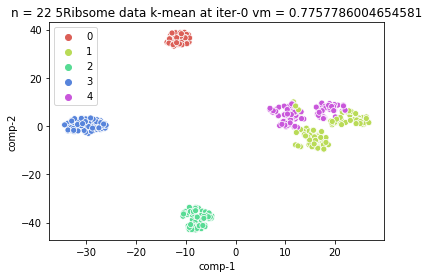

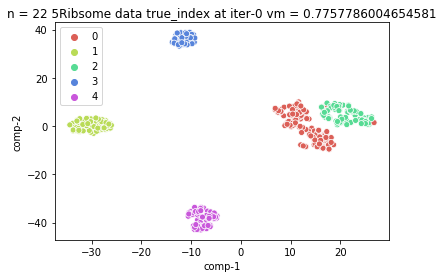

/home/users/lewis841214/Desktop/1project/CryoEMCode/GPU_CryoEM/tomosipo/tomosipo/links/torch.py:64: UserWarning: The parameter initial_value should be contiguous. It has been automatically made contiguous. Use `ts.link(x.contiguous())' to inhibit this warning. 
  f"The parameter initial_value should be contiguous. "


1282.452996969223 sec
0 batch 1 iteration
generated


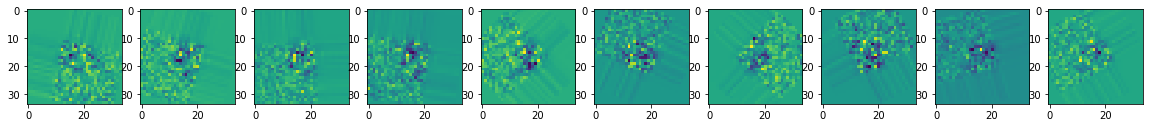

real


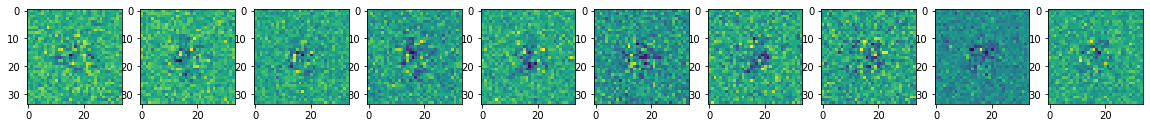

1283.3516426086426 sec
0 batch 2 iteration
generated


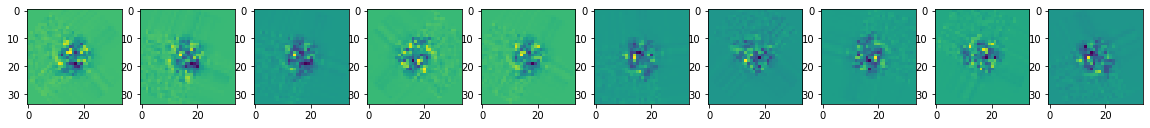

real


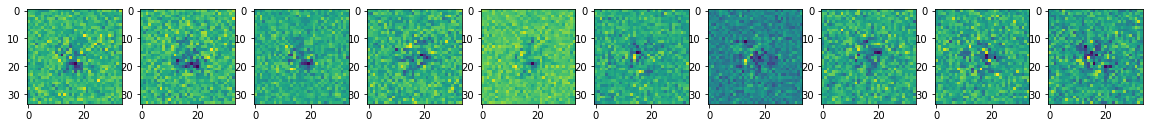

KeyboardInterrupt: 

In [18]:
#n_list = [2,5,6,7, 10, 15,18]#, 22]
n_list = [2,5,6,7, 10, 15, 22]
n_list.reverse()
#b_list = [400,400,400, 400, 200,100 , 100]#, 100]
b_list = [400,400,400, 400, 200,140 , 100]
b_list.reverse()
iter_list = [40 for i in range(len(n_list))]
for i in range(len(n_list)):
    n = n_list[i]
    b = b_list[i]
    niter = iter_list[i]
    Images = new_projection[:9200]
    print(Images.shape)
    exp_name = f'20220112_n_{n}_MPCA_noised_SNR_{sn_ratio}_initial_atMid'
    ProjSize, num_image, n_component , num_iter = 34, 9200, n, niter
    batch_size = b
    Vol_geom = astra.create_vol_geom(34, 34, 34)
    #Images = torch.ones(num_image, 48, 48) # fake images for computing purpose
    """
    Proj_geom = astra.create_proj_geom('parallel3d_vec', ProjSize, ProjSize, Orientation_Vectors)
    Vol_geom = astra.create_vol_geom(32, 32, 32)
    vg = ts.from_astra(Vol_geom)
    pg = ts.from_astra(Proj_geom)
    op = ts.operator(vg, pg)
    """
    vg = ts.from_astra(Vol_geom)
    pg = ts.from_astra(Proj_geom)
    op = ts.operator(vg, pg)
    MP3 = MPCA_3d_recon(ProjSize, num_image, n_component, op , Images, exp_name, batch_size, niter)
    MP3.fit(start_ratio = 0.1)
"""
MP3.A_pro_All_U()

MP3.Plot_temp()
MP3.Q_Function()

MP3.Expectation()
MP3.Q_Function()
MP3.Maximization()
MP3.Plot_temp()
MP3.Q_Function()
print(MP3.All_U.shape)
"""


In [ ]:
#Run 

In [ ]:
"""
U1 = torch.load('./snap_shot/1229_n_22_MPCA_sigma_j_monitor_0th_55_U1.pt')
U2 = torch.load('./snap_shot/1229_n_22_MPCA_sigma_j_monitor_0th_55_U2.pt')
U3 = torch.load('./snap_shot/1229_n_22_MPCA_sigma_j_monitor_0th_55_U3.pt')
MP3.U1.data = U1.detach()
MP3.U2.data = U2.detach()
MP3.U3.data = U3.detach()
"""

#MP3.fit(start_ratio = 0.1)


In [24]:
lr = torch.mean(torch.abs(MP3.U1)) * 0.1
print(torch.mean(torch.abs(MP3.U1)))

tensor(0.1048, grad_fn=<MeanBackward0>)


In [ ]:
#increase batch_size, decrease learning rate
#first load 15 trained component from n = 15 set
"""
U1 = torch.load('./snap_shot/1227_n_18_MPCA_0th_U1.pt')
U2 = torch.load('./snap_shot/1227_n_18_MPCA_0th_U1.pt')
U3 = torch.load('./snap_shot/1227_n_18_MPCA_0th_U1.pt')
MP3.U1.data = U1.detach()
MP3.U2.data = U2.detach()
MP3.U3.data = U3.detach()

"""




#MP3.fit(start_ratio = 0.1)



torch.mean(self.mu) tensor(0.0839)
torch.mean(self.BigSigma_I) tensor(0.0106)
monotor sigma j max tensor(3.8480)
generated


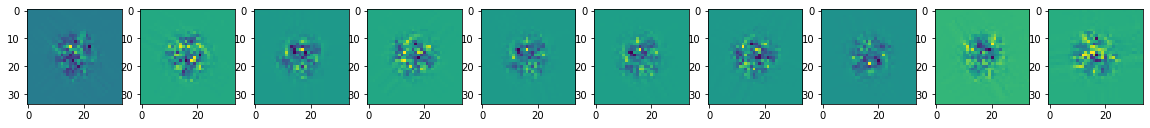

real


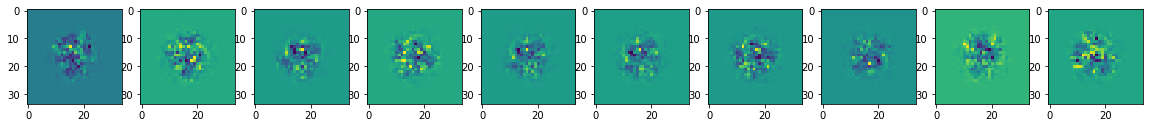

torch.mean(self.mu) tensor(0.1073)
torch.mean(self.BigSigma_I) tensor(0.0151)
monotor sigma j max tensor(3.8480)
generated


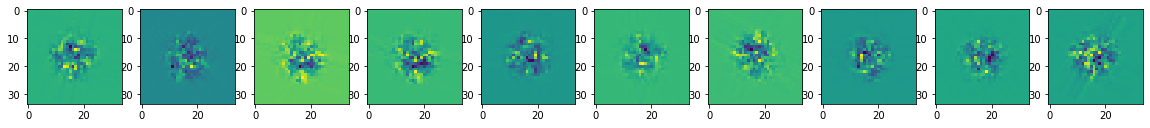

real


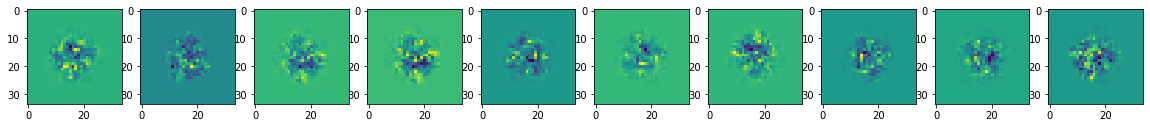

torch.mean(self.mu) tensor(0.1074)
torch.mean(self.BigSigma_I) tensor(0.0143)
monotor sigma j max tensor(3.8480)
generated


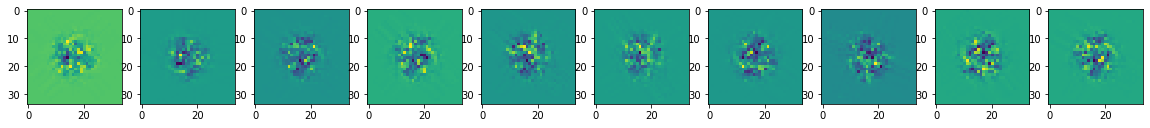

real


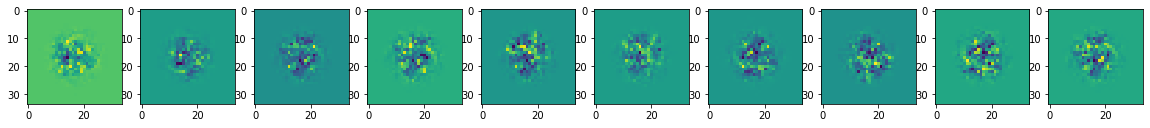

torch.mean(self.mu) tensor(0.1078)
torch.mean(self.BigSigma_I) tensor(0.0143)
monotor sigma j max tensor(3.8480)
generated


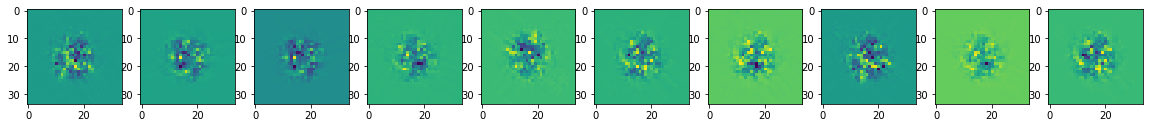

real


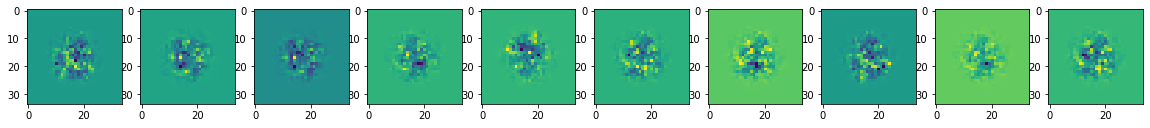

torch.mean(self.mu) tensor(0.1020)
torch.mean(self.BigSigma_I) tensor(0.0130)
monotor sigma j max tensor(3.8480)
generated


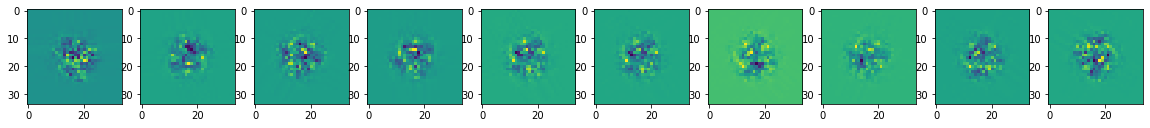

real


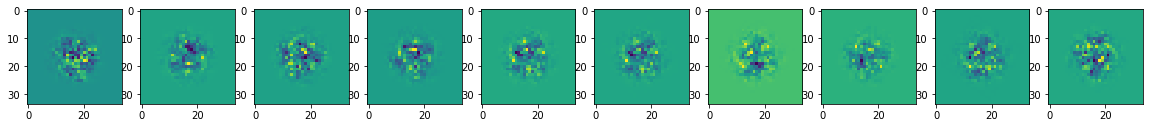

torch.mean(self.mu) tensor(0.1045)
torch.mean(self.BigSigma_I) tensor(0.0144)
monotor sigma j max tensor(3.8480)
generated


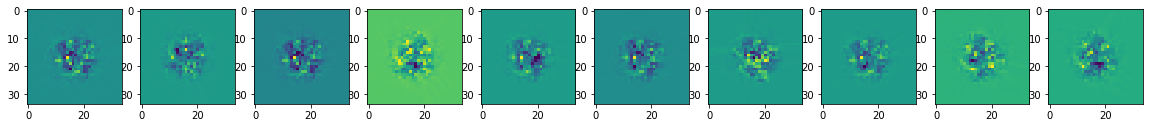

real


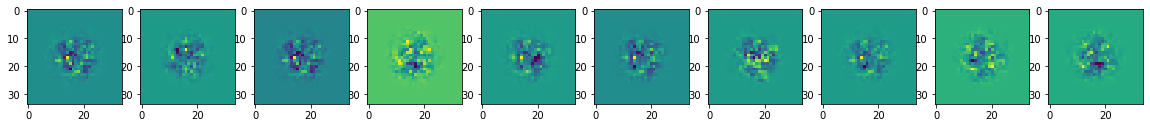

torch.mean(self.mu) tensor(0.1008)
torch.mean(self.BigSigma_I) tensor(0.0142)
monotor sigma j max tensor(3.8480)
generated


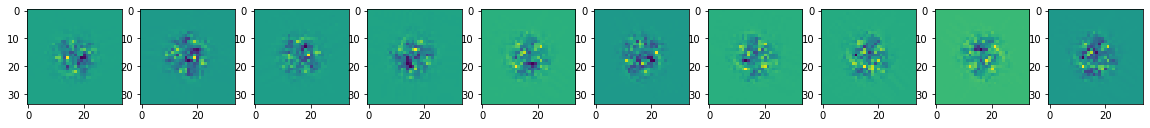

real


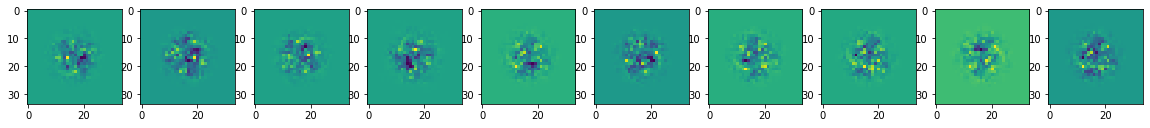

torch.mean(self.mu) tensor(0.1088)
torch.mean(self.BigSigma_I) tensor(0.0160)
monotor sigma j max tensor(3.8480)
generated


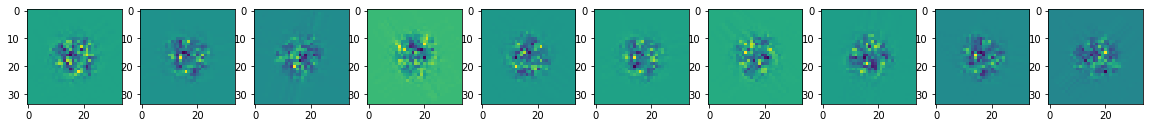

real


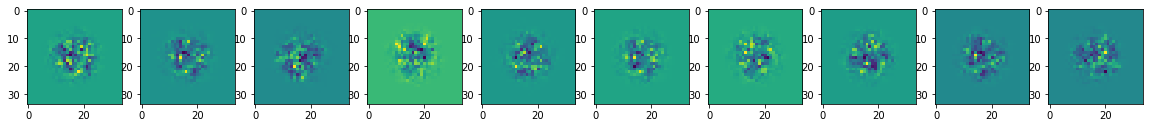

torch.mean(self.mu) tensor(0.0987)
torch.mean(self.BigSigma_I) tensor(0.0143)
monotor sigma j max tensor(3.8480)
generated


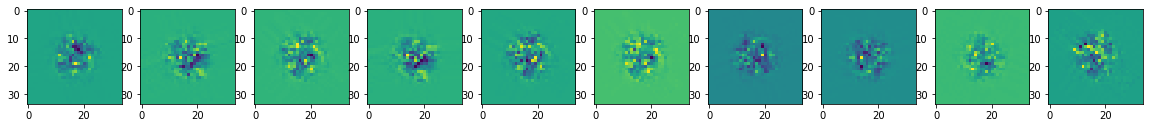

real


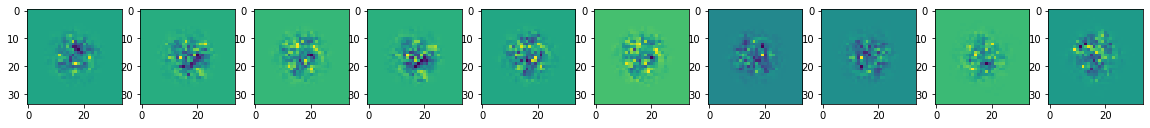

torch.mean(self.mu) tensor(0.1022)
torch.mean(self.BigSigma_I) tensor(0.0139)
monotor sigma j max tensor(3.8480)
generated


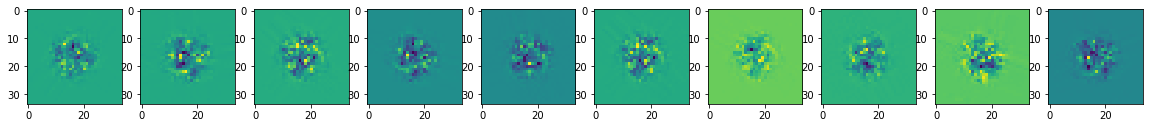

real


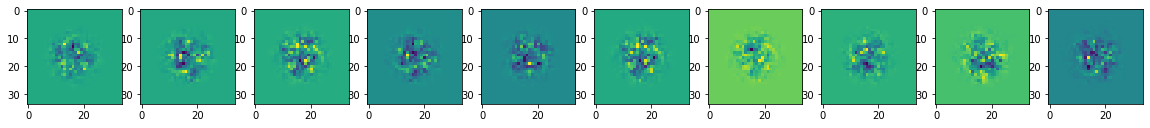

torch.mean(self.mu) tensor(0.1021)
torch.mean(self.BigSigma_I) tensor(0.0149)
monotor sigma j max tensor(3.8480)
generated


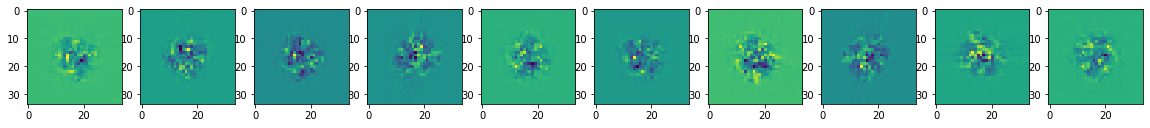

real


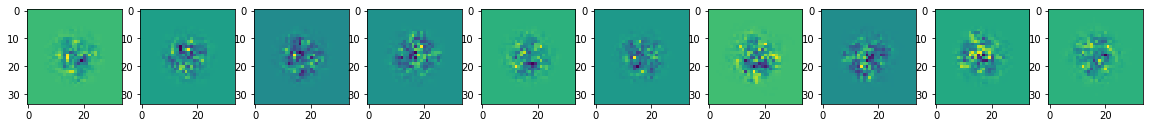

torch.mean(self.mu) tensor(0.1041)
torch.mean(self.BigSigma_I) tensor(0.0140)
monotor sigma j max tensor(3.8480)
generated


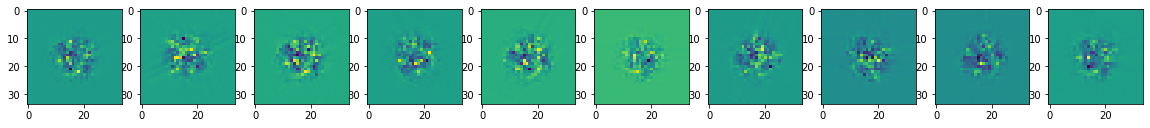

real


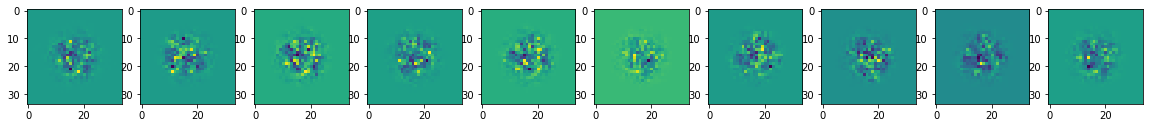

torch.mean(self.mu) tensor(0.0965)
torch.mean(self.BigSigma_I) tensor(0.0146)
monotor sigma j max tensor(3.8480)
generated


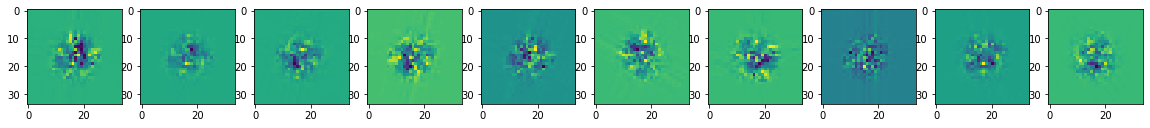

real


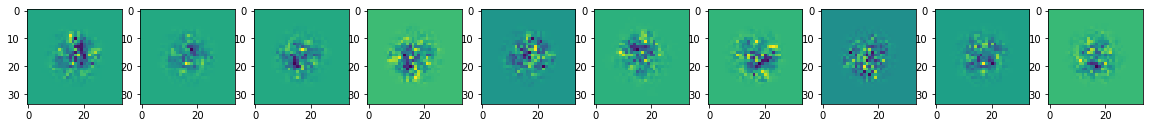

torch.mean(self.mu) tensor(0.1013)
torch.mean(self.BigSigma_I) tensor(0.0138)
monotor sigma j max tensor(3.8480)
generated


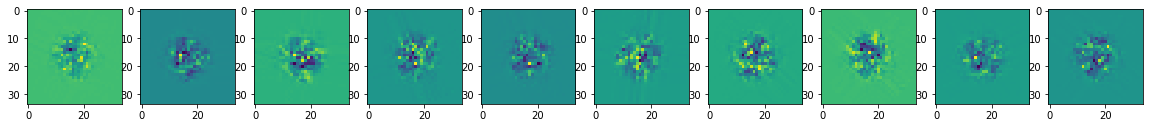

real


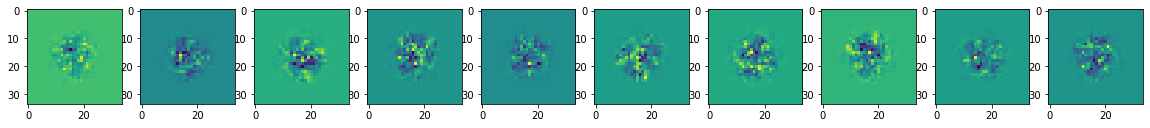

torch.mean(self.mu) tensor(0.1044)
torch.mean(self.BigSigma_I) tensor(0.0150)
monotor sigma j max tensor(3.8480)
generated


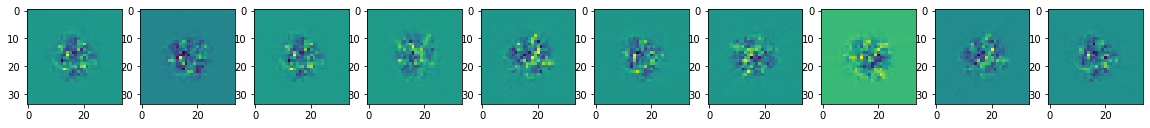

real


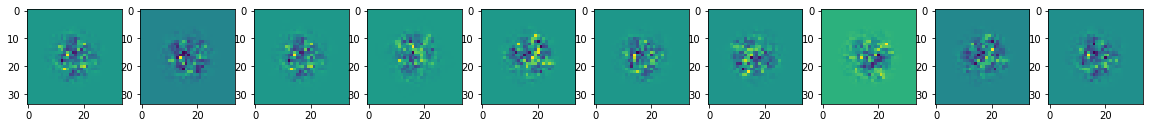

torch.mean(self.mu) tensor(0.1034)
torch.mean(self.BigSigma_I) tensor(0.0138)
monotor sigma j max tensor(3.8480)
generated


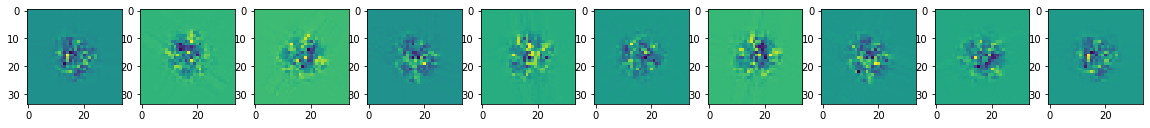

real


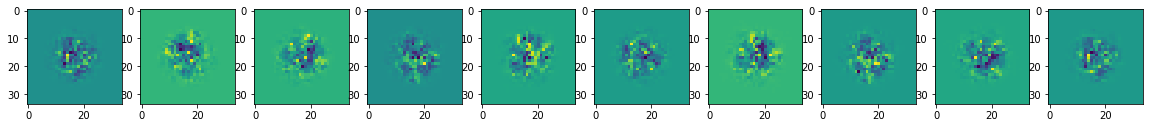

torch.mean(self.mu) tensor(0.0956)
torch.mean(self.BigSigma_I) tensor(0.0122)
monotor sigma j max tensor(3.8480)
generated


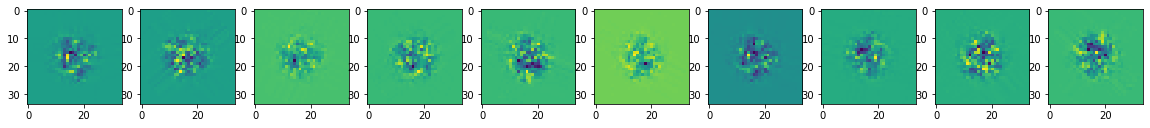

real


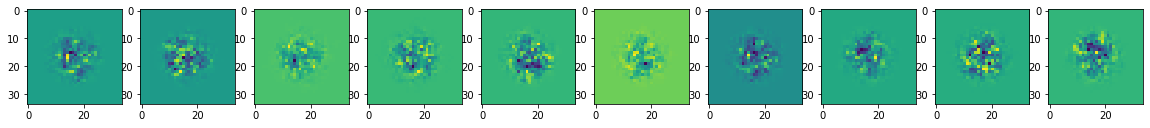

torch.mean(self.mu) tensor(0.0957)
torch.mean(self.BigSigma_I) tensor(0.0117)
monotor sigma j max tensor(3.8480)
generated


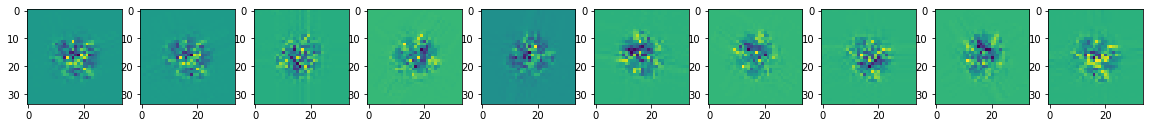

real


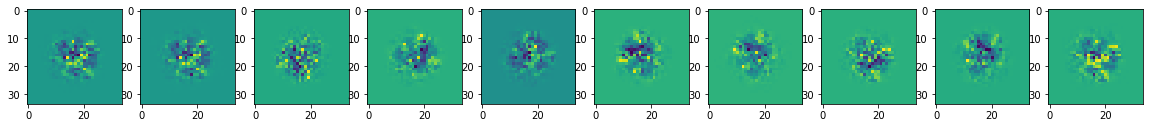

torch.mean(self.mu) tensor(0.1097)
torch.mean(self.BigSigma_I) tensor(0.0158)
monotor sigma j max tensor(3.8480)
generated


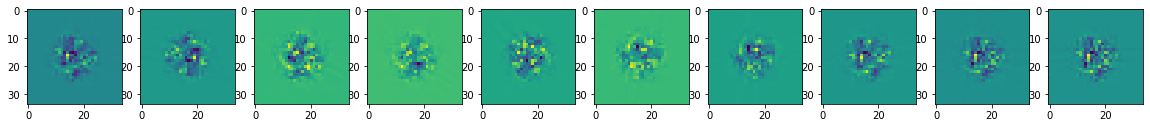

real


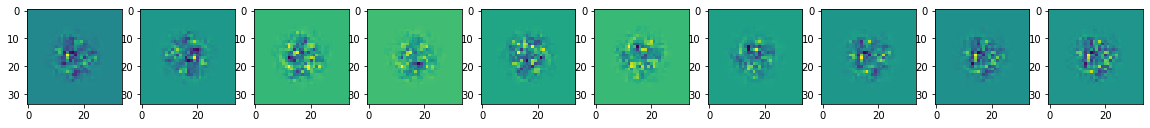

torch.mean(self.mu) tensor(0.1057)
torch.mean(self.BigSigma_I) tensor(0.0147)
monotor sigma j max tensor(3.8480)
generated


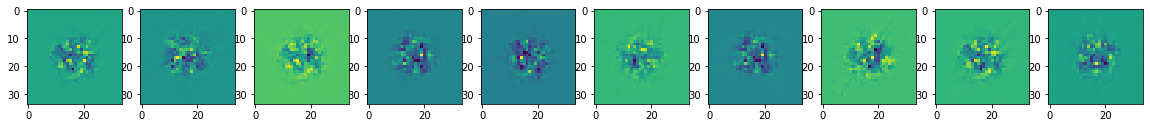

real


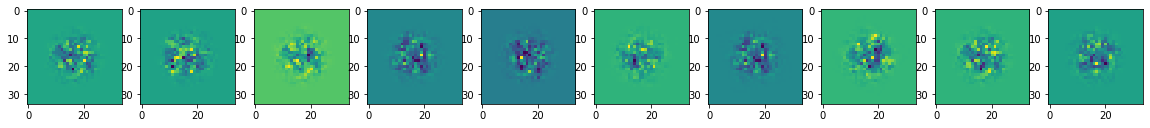

torch.mean(self.mu) tensor(0.0964)
torch.mean(self.BigSigma_I) tensor(0.0126)
monotor sigma j max tensor(3.8480)
generated


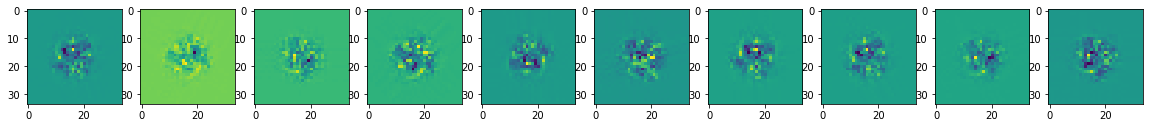

real


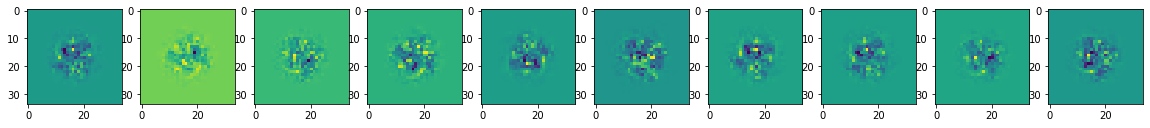

torch.mean(self.mu) tensor(0.1039)
torch.mean(self.BigSigma_I) tensor(0.0143)
monotor sigma j max tensor(3.8480)
generated


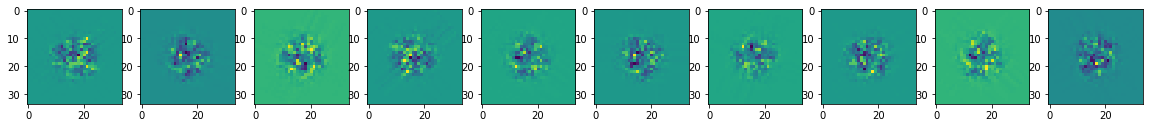

real


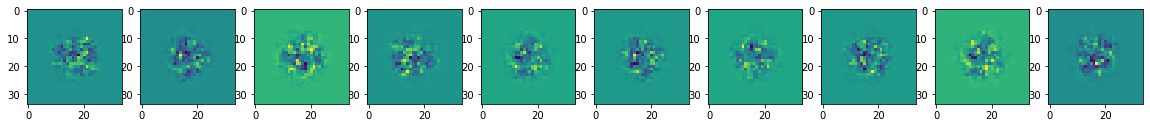

torch.mean(self.mu) tensor(0.1059)
torch.mean(self.BigSigma_I) tensor(0.0143)
monotor sigma j max tensor(3.8480)
generated


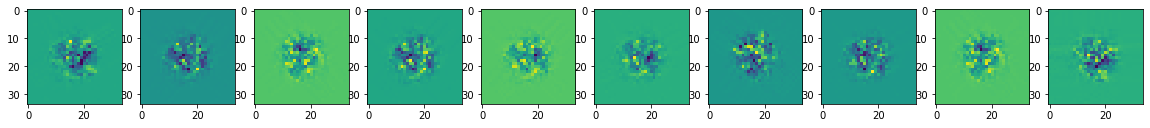

real


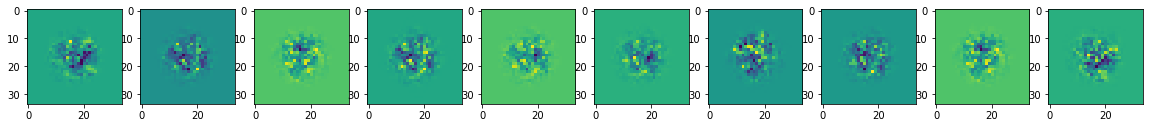

torch.mean(self.mu) tensor(0.1025)
torch.mean(self.BigSigma_I) tensor(0.0141)
monotor sigma j max tensor(3.8480)
generated


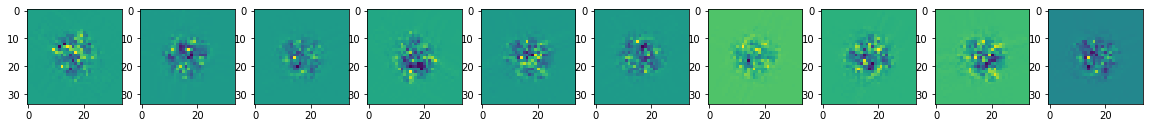

real


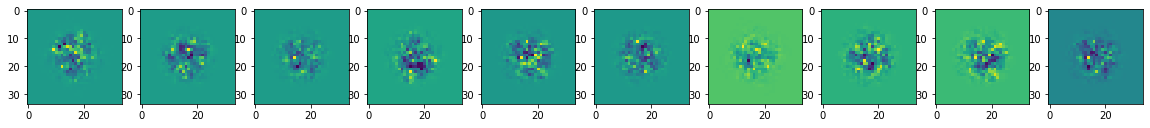

torch.mean(self.mu) tensor(0.1014)
torch.mean(self.BigSigma_I) tensor(0.0134)
monotor sigma j max tensor(3.8480)
generated


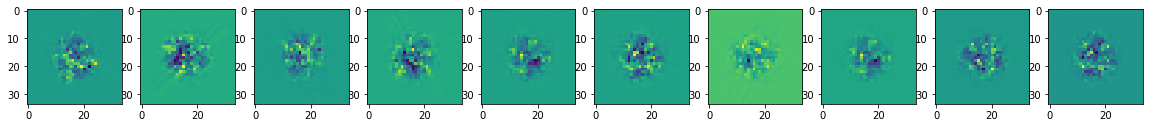

real


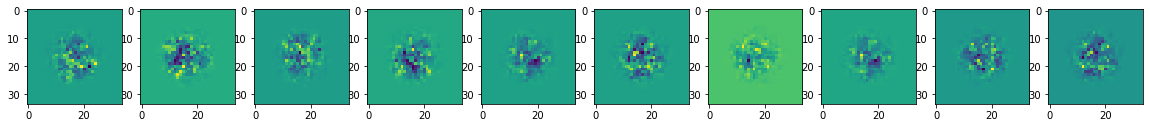

torch.mean(self.mu) tensor(0.0948)
torch.mean(self.BigSigma_I) tensor(0.0132)
monotor sigma j max tensor(3.8480)
generated


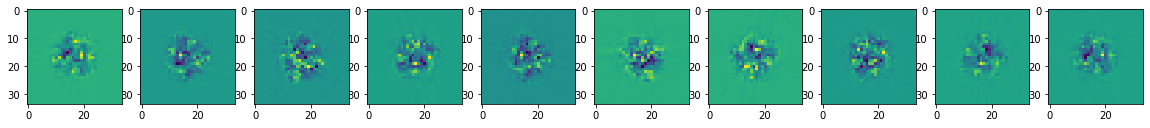

real


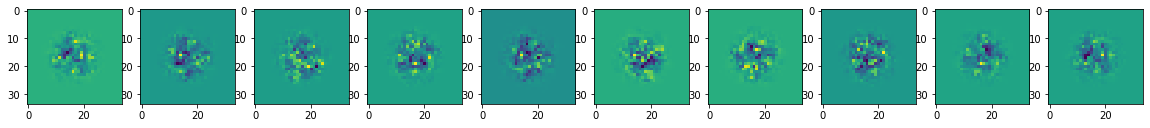

torch.mean(self.mu) tensor(0.1056)
torch.mean(self.BigSigma_I) tensor(0.0145)
monotor sigma j max tensor(3.8480)
generated


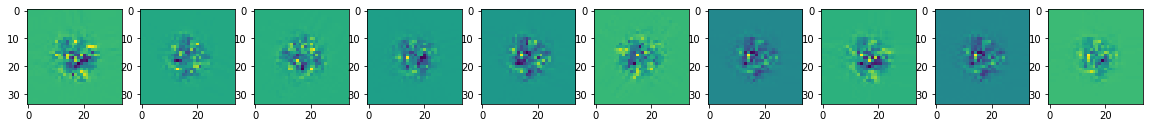

real


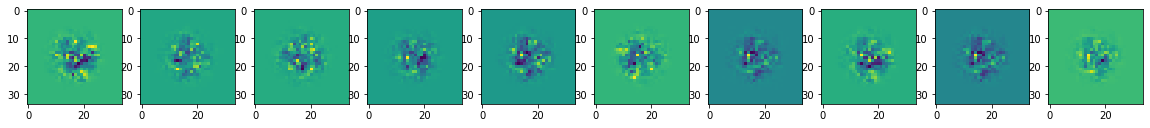

torch.mean(self.mu) tensor(0.0991)
torch.mean(self.BigSigma_I) tensor(0.0131)
monotor sigma j max tensor(3.8480)
generated


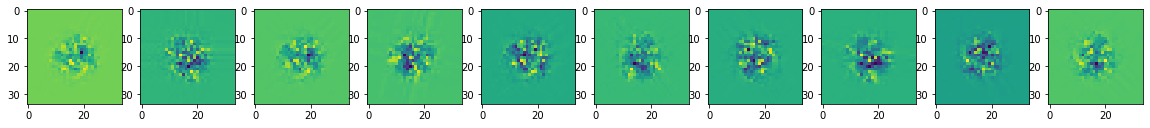

real


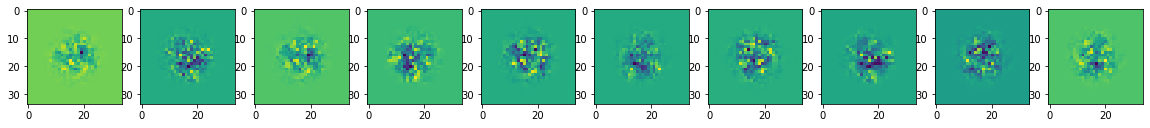

torch.mean(self.mu) tensor(0.1049)
torch.mean(self.BigSigma_I) tensor(0.0140)
monotor sigma j max tensor(3.8480)
generated


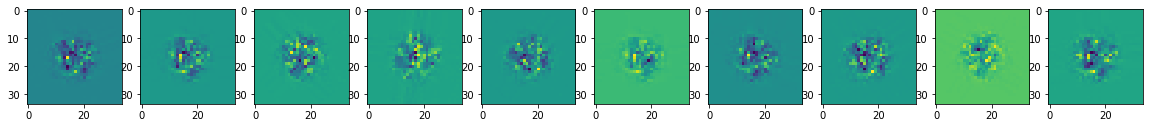

real


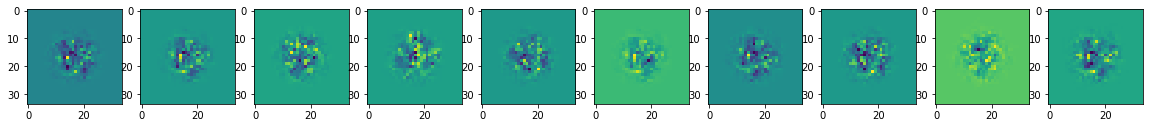

torch.mean(self.mu) tensor(0.0981)
torch.mean(self.BigSigma_I) tensor(0.0128)
monotor sigma j max tensor(3.8480)
generated


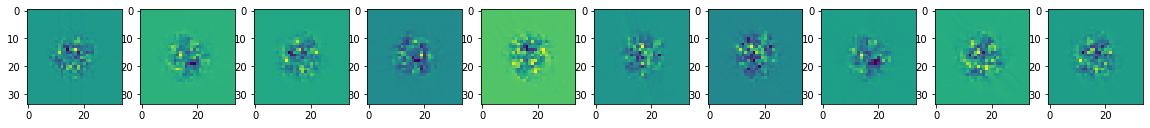

real


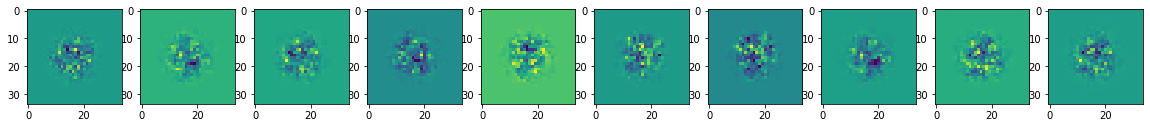

torch.mean(self.mu) tensor(0.1006)
torch.mean(self.BigSigma_I) tensor(0.0141)
monotor sigma j max tensor(3.8480)
generated


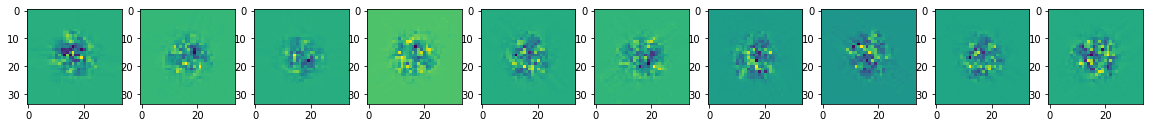

real


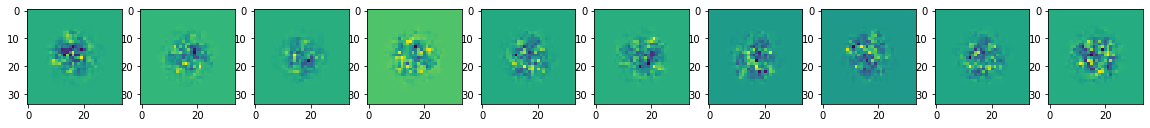

torch.mean(self.mu) tensor(0.0998)
torch.mean(self.BigSigma_I) tensor(0.0130)
monotor sigma j max tensor(3.8480)
generated


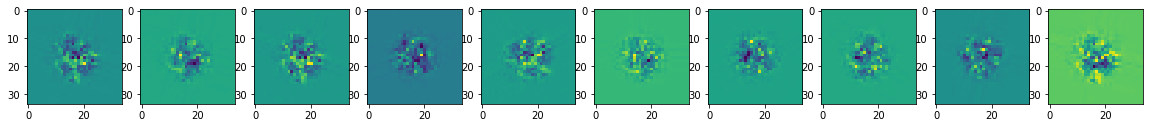

real


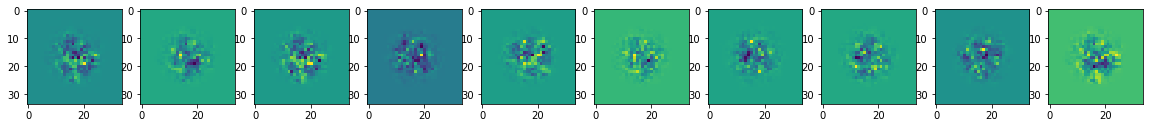

torch.mean(self.mu) tensor(0.0991)
torch.mean(self.BigSigma_I) tensor(0.0131)
monotor sigma j max tensor(3.8480)
generated


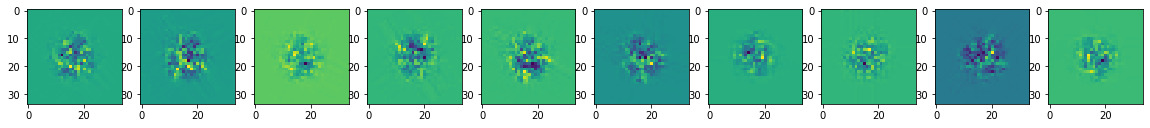

real


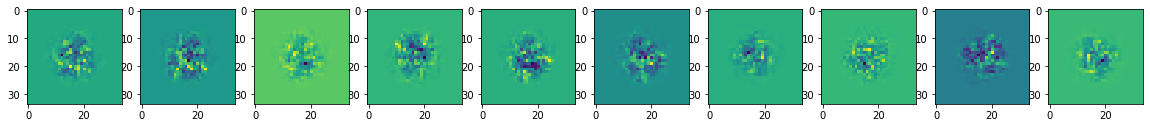

torch.mean(self.mu) tensor(0.0966)
torch.mean(self.BigSigma_I) tensor(0.0129)
monotor sigma j max tensor(3.8480)
generated


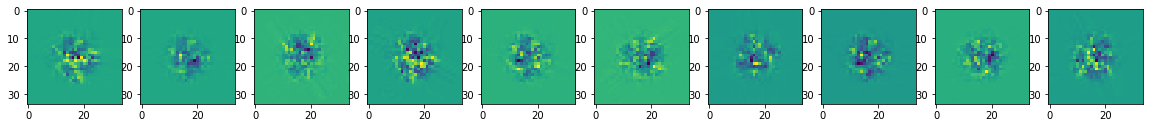

real


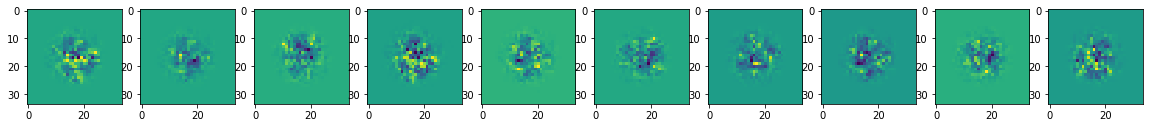

torch.mean(self.mu) tensor(0.1051)
torch.mean(self.BigSigma_I) tensor(0.0140)
monotor sigma j max tensor(3.8480)
generated


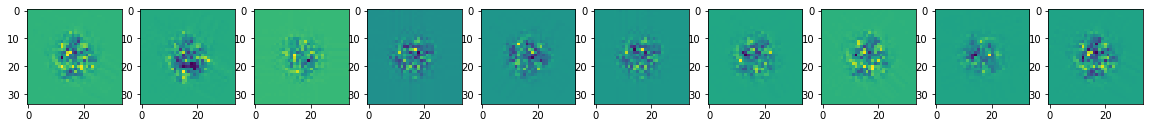

real


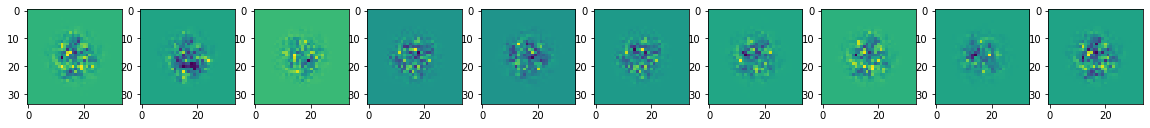

torch.mean(self.mu) tensor(0.1046)
torch.mean(self.BigSigma_I) tensor(0.0147)
monotor sigma j max tensor(3.8480)
generated


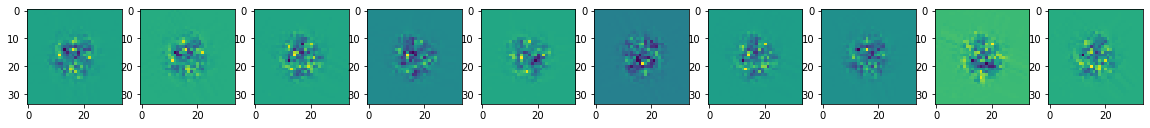

real


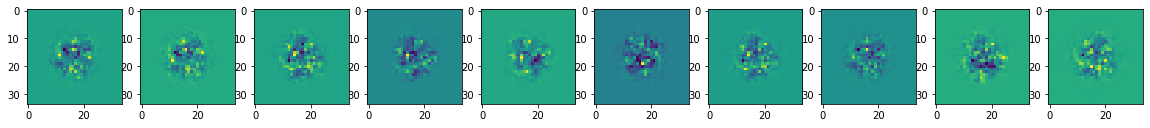

torch.mean(self.mu) tensor(0.1031)
torch.mean(self.BigSigma_I) tensor(0.0130)
monotor sigma j max tensor(3.8480)
generated


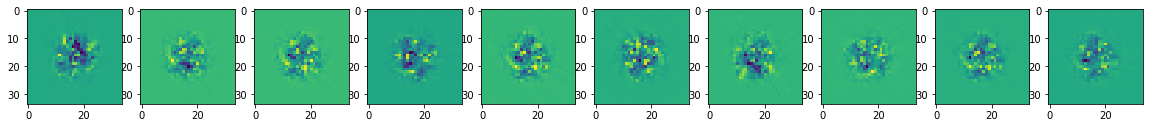

real


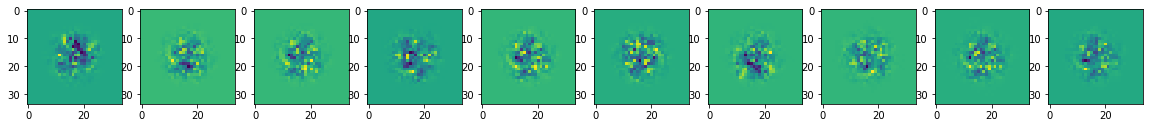

torch.mean(self.mu) tensor(0.0955)
torch.mean(self.BigSigma_I) tensor(0.0128)
monotor sigma j max tensor(3.8480)
generated


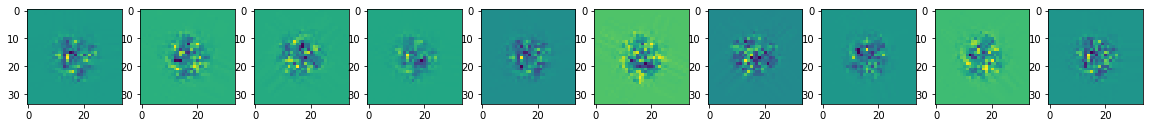

real


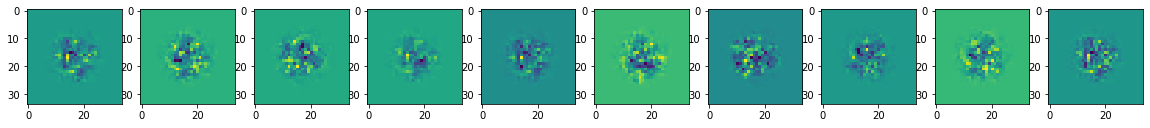

torch.mean(self.mu) tensor(0.1026)
torch.mean(self.BigSigma_I) tensor(0.0144)
monotor sigma j max tensor(3.8480)
generated


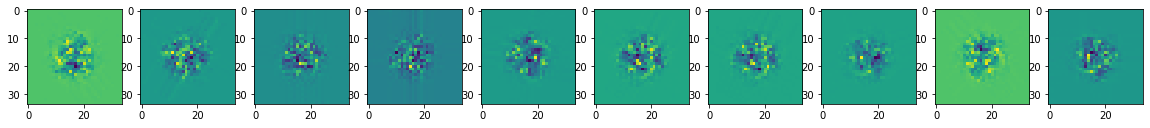

real


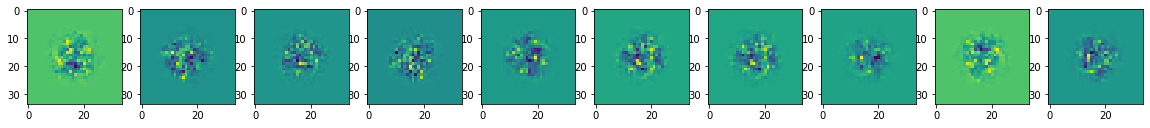

torch.mean(self.mu) tensor(0.1072)
torch.mean(self.BigSigma_I) tensor(0.0155)
monotor sigma j max tensor(3.8480)
generated


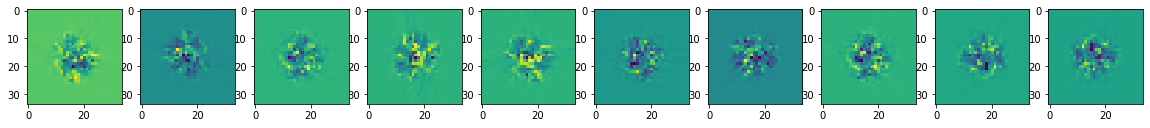

real


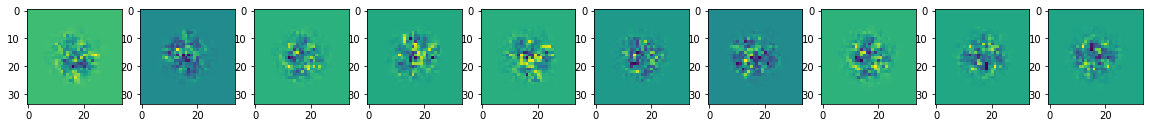

torch.mean(self.mu) tensor(0.0904)
torch.mean(self.BigSigma_I) tensor(0.0113)
monotor sigma j max tensor(3.8480)
generated


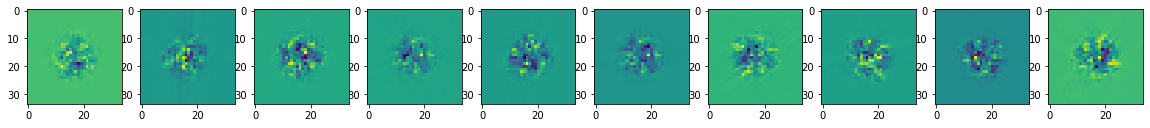

real


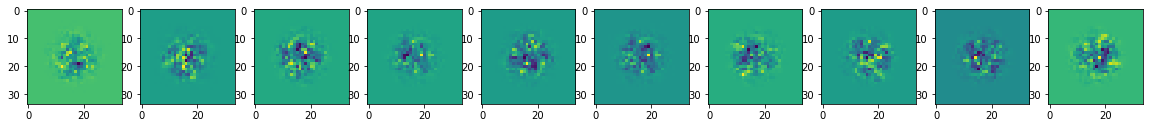

torch.mean(self.mu) tensor(0.0899)
torch.mean(self.BigSigma_I) tensor(0.0110)
monotor sigma j max tensor(3.8480)
generated


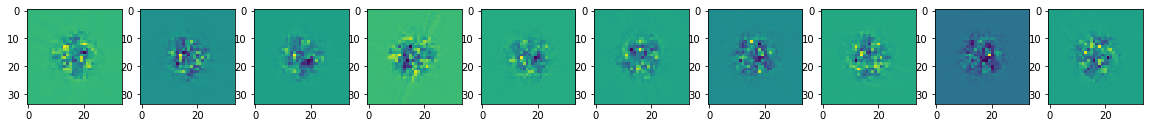

real


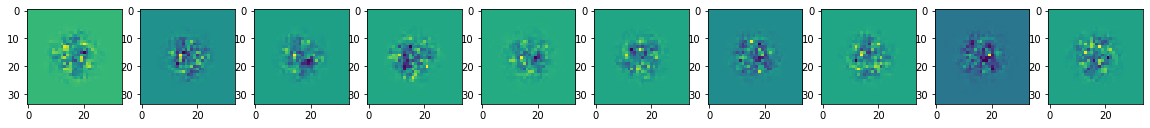

torch.mean(self.mu) tensor(0.1005)
torch.mean(self.BigSigma_I) tensor(0.0139)
monotor sigma j max tensor(3.8480)
generated


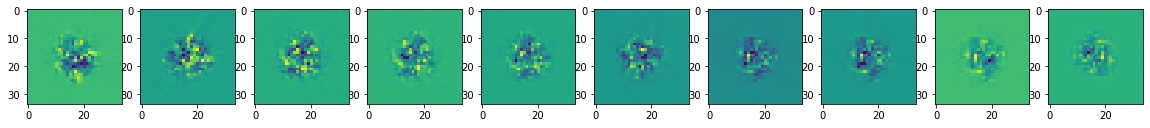

real


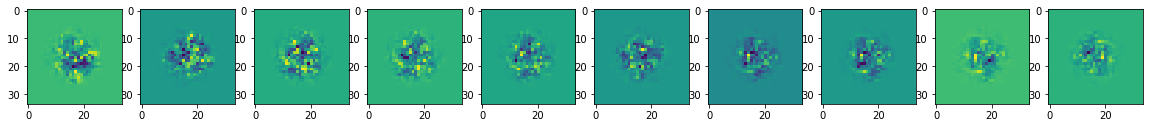

torch.mean(self.mu) tensor(0.1034)
torch.mean(self.BigSigma_I) tensor(0.0141)
monotor sigma j max tensor(3.8480)
generated


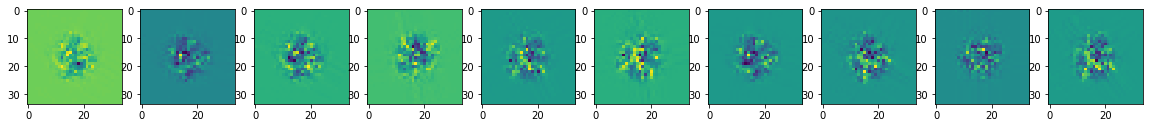

real


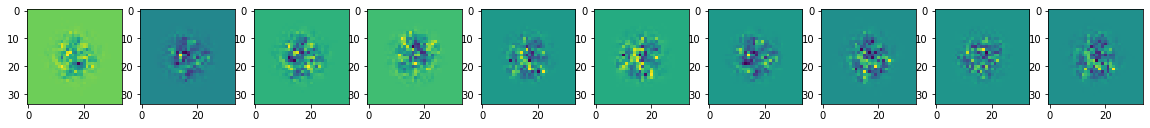

torch.mean(self.mu) tensor(0.1007)
torch.mean(self.BigSigma_I) tensor(0.0134)
monotor sigma j max tensor(3.8480)
generated


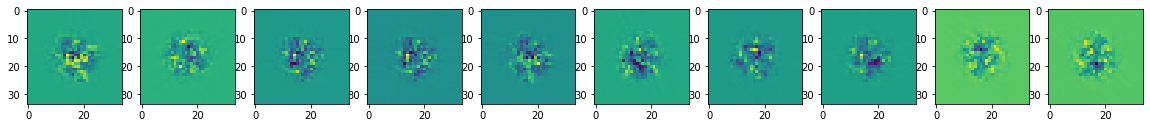

real


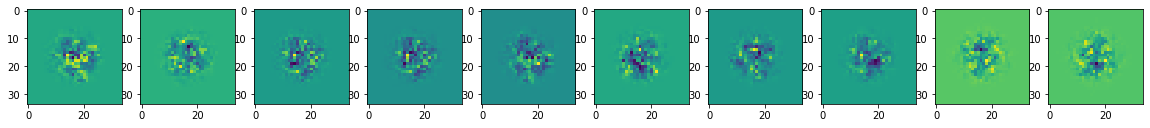

torch.mean(self.mu) tensor(0.0956)
torch.mean(self.BigSigma_I) tensor(0.0131)
monotor sigma j max tensor(3.8480)
generated


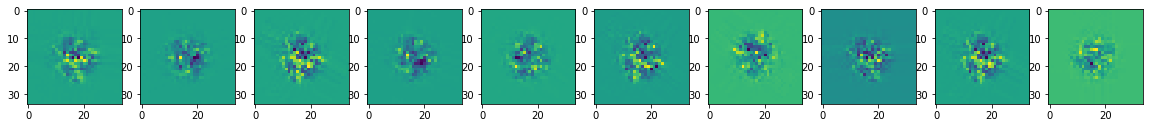

real


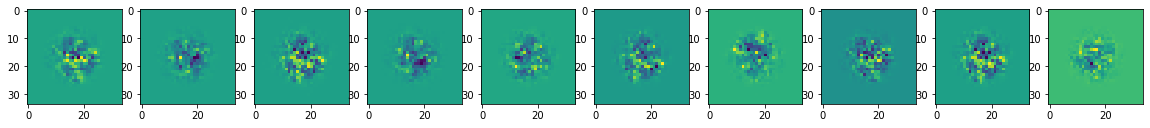

torch.mean(self.mu) tensor(0.0969)
torch.mean(self.BigSigma_I) tensor(0.0120)
monotor sigma j max tensor(3.8480)
generated


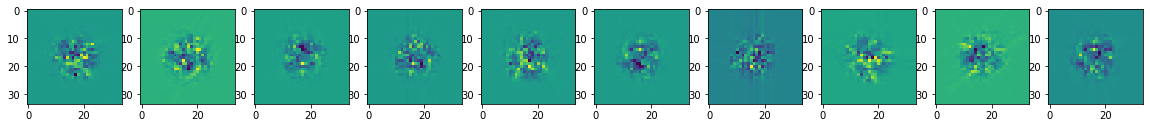

real


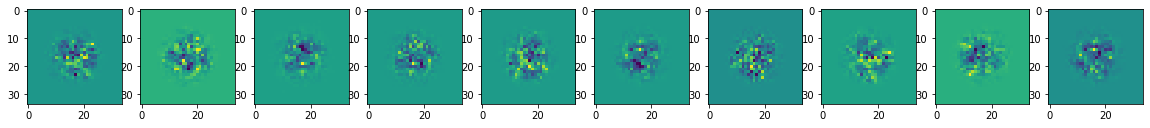

torch.mean(self.mu) tensor(0.1120)
torch.mean(self.BigSigma_I) tensor(0.0153)
monotor sigma j max tensor(3.8480)
generated


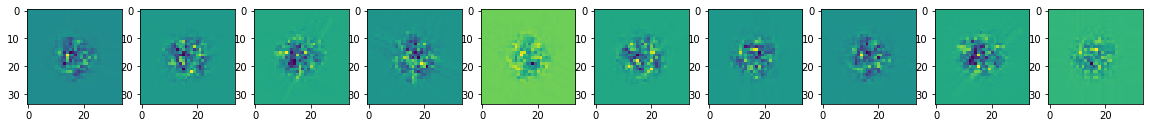

real


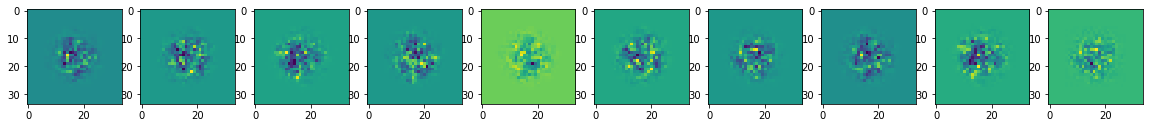

torch.mean(self.mu) tensor(0.1011)
torch.mean(self.BigSigma_I) tensor(0.0137)
monotor sigma j max tensor(3.8480)
generated


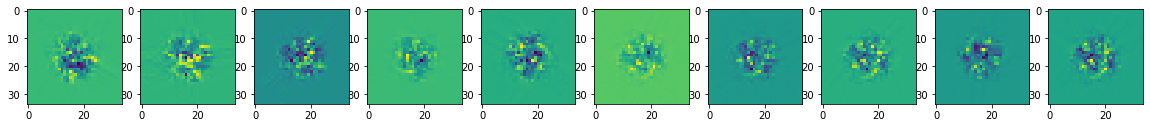

real


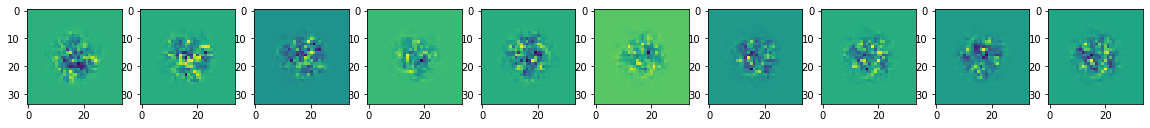

torch.mean(self.mu) tensor(0.1031)
torch.mean(self.BigSigma_I) tensor(0.0142)
monotor sigma j max tensor(3.8480)
generated


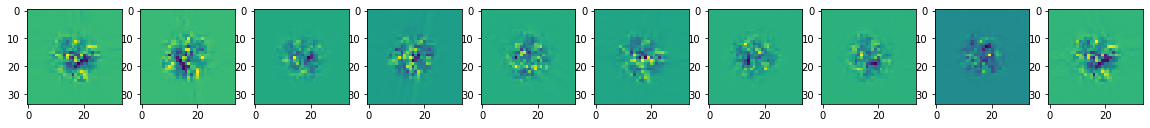

real


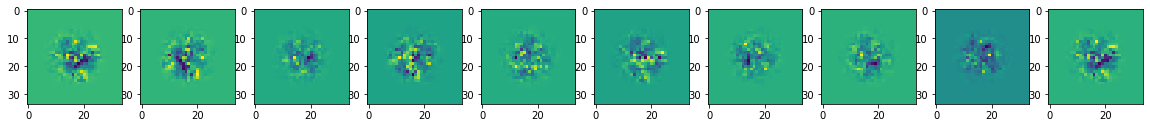

torch.mean(self.mu) tensor(0.1143)
torch.mean(self.BigSigma_I) tensor(0.0168)
monotor sigma j max tensor(3.8480)
generated


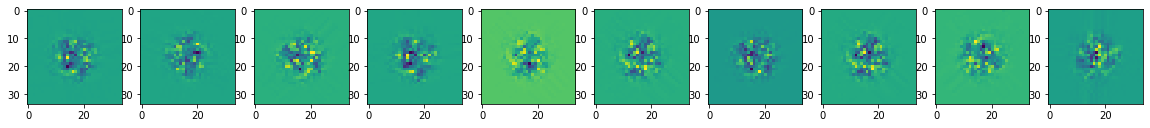

real


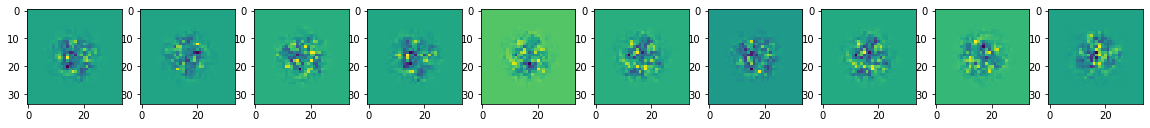

torch.mean(self.mu) tensor(0.1012)
torch.mean(self.BigSigma_I) tensor(0.0129)
monotor sigma j max tensor(3.8480)
generated


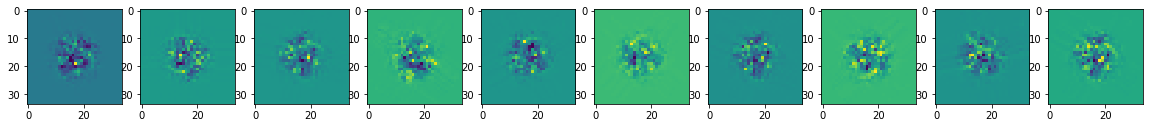

real


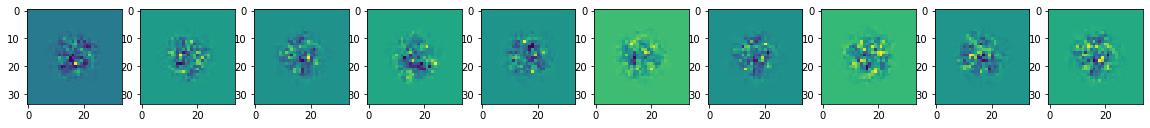

torch.mean(self.mu) tensor(0.1095)
torch.mean(self.BigSigma_I) tensor(0.0150)
monotor sigma j max tensor(3.8480)
generated


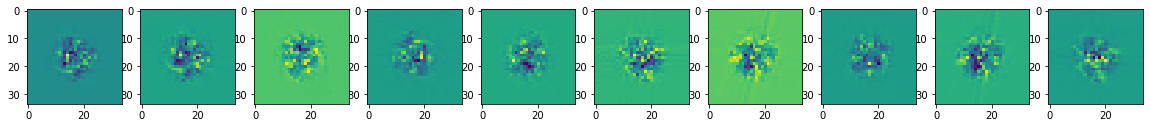

real


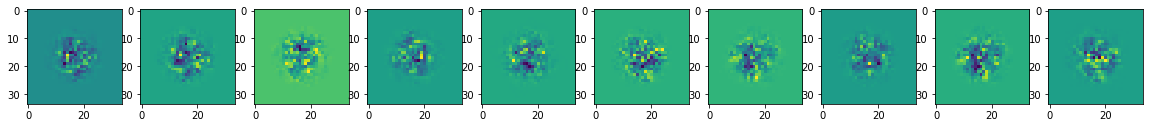

torch.mean(self.mu) tensor(0.1038)
torch.mean(self.BigSigma_I) tensor(0.0150)
monotor sigma j max tensor(3.8480)
generated


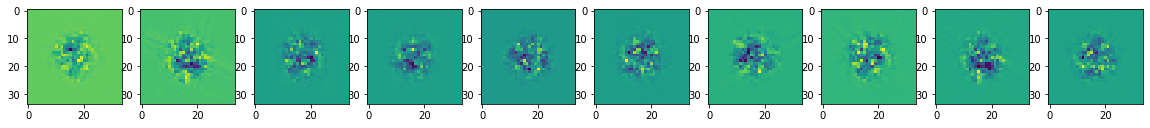

real


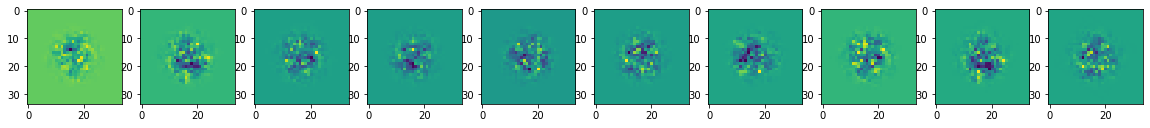

torch.mean(self.mu) tensor(0.1053)
torch.mean(self.BigSigma_I) tensor(0.0145)
monotor sigma j max tensor(3.8480)
generated


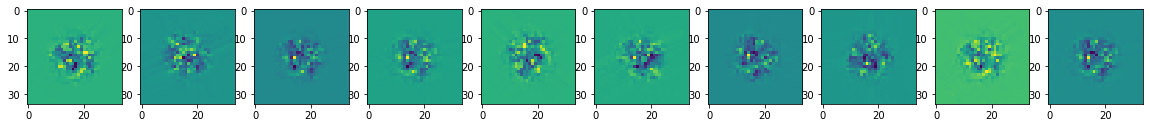

real


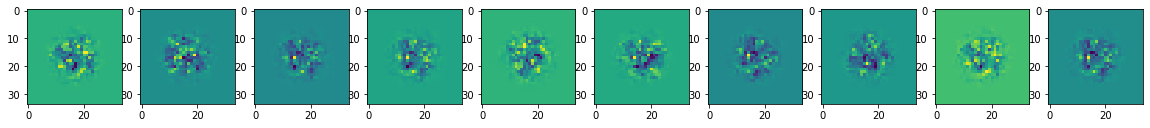

torch.mean(self.mu) tensor(0.1041)
torch.mean(self.BigSigma_I) tensor(0.0144)
monotor sigma j max tensor(3.8480)
generated


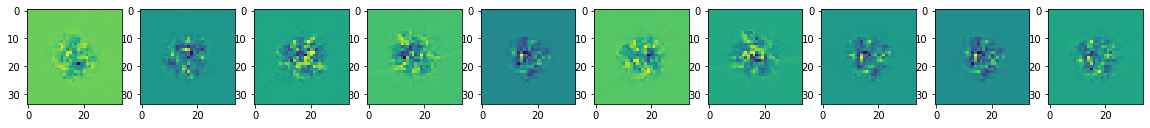

real


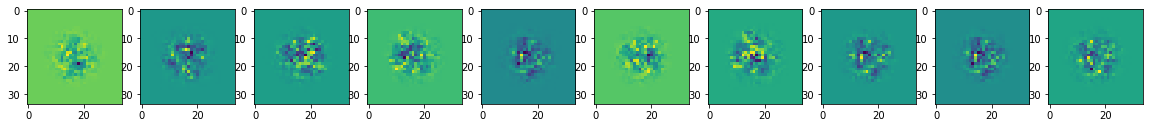

torch.mean(self.mu) tensor(0.1011)
torch.mean(self.BigSigma_I) tensor(0.0136)
monotor sigma j max tensor(3.8480)
generated


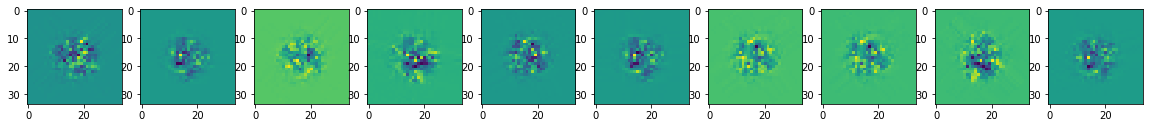

real


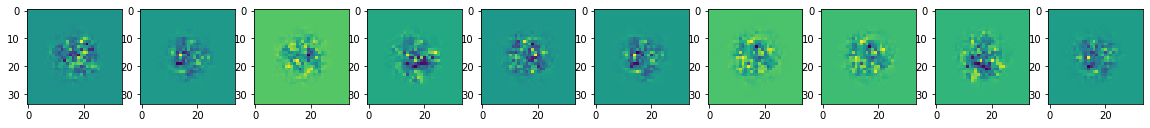

torch.mean(self.mu) tensor(0.0985)
torch.mean(self.BigSigma_I) tensor(0.0123)
monotor sigma j max tensor(3.8480)
generated


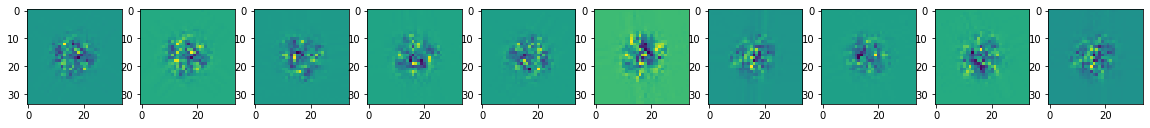

real


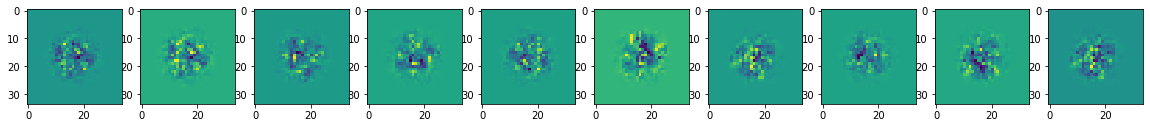

torch.mean(self.mu) tensor(0.1078)
torch.mean(self.BigSigma_I) tensor(0.0149)
monotor sigma j max tensor(3.8480)
generated


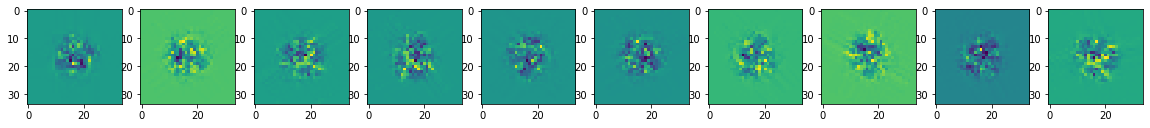

real


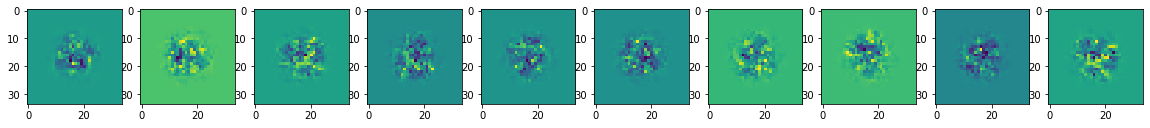

torch.mean(self.mu) tensor(0.0949)
torch.mean(self.BigSigma_I) tensor(0.0121)
monotor sigma j max tensor(3.8480)
generated


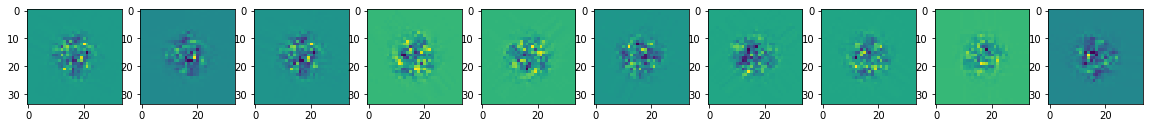

real


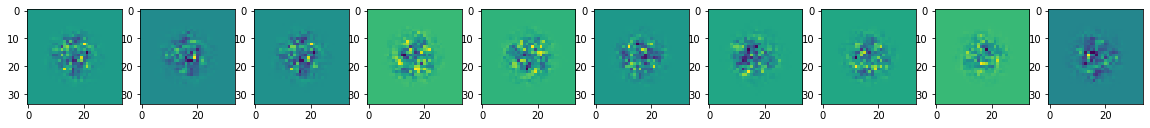

torch.mean(self.mu) tensor(0.1072)
torch.mean(self.BigSigma_I) tensor(0.0145)
monotor sigma j max tensor(3.8480)
generated


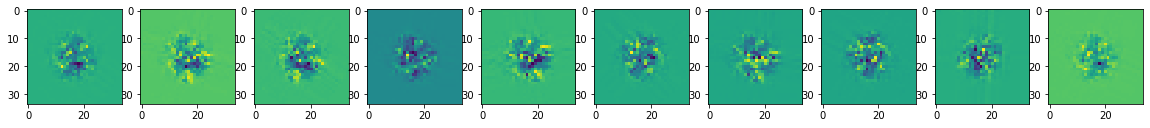

real


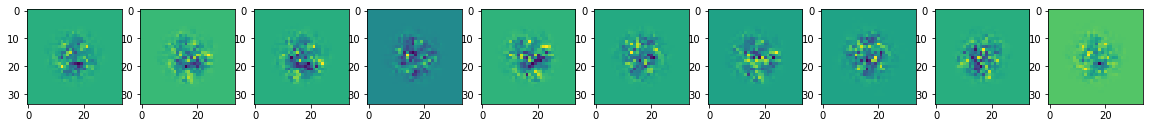

torch.mean(self.mu) tensor(0.1031)
torch.mean(self.BigSigma_I) tensor(0.0136)
monotor sigma j max tensor(3.8480)
generated


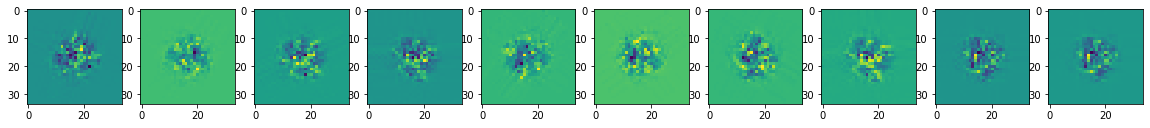

real


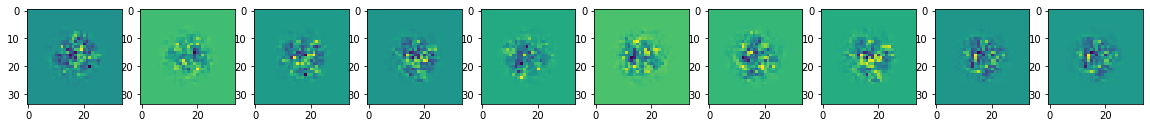

torch.mean(self.mu) tensor(0.1043)
torch.mean(self.BigSigma_I) tensor(0.0135)
monotor sigma j max tensor(3.8480)
generated


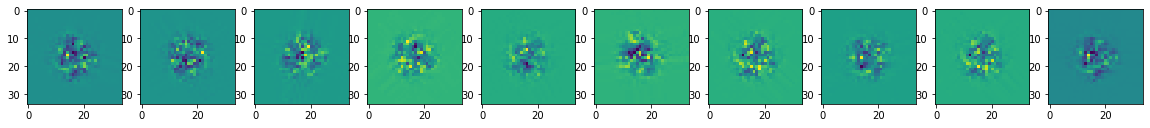

real


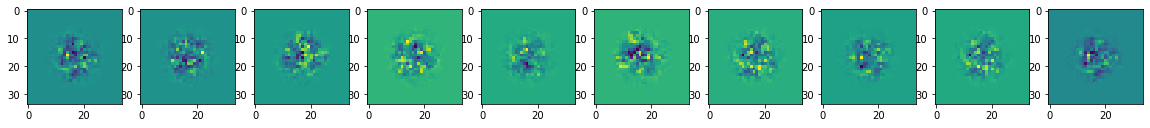

torch.mean(self.mu) tensor(0.1102)
torch.mean(self.BigSigma_I) tensor(0.0156)
monotor sigma j max tensor(3.8480)
generated


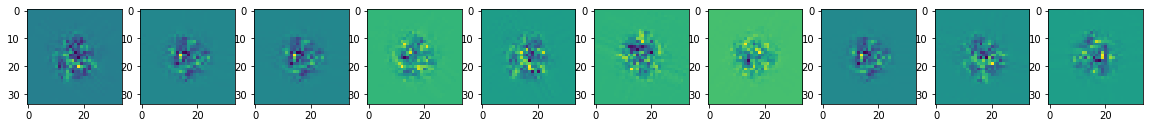

real


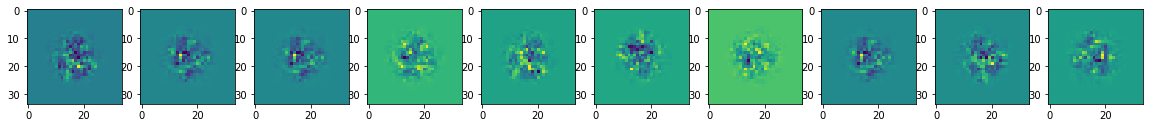

torch.mean(self.mu) tensor(0.1065)
torch.mean(self.BigSigma_I) tensor(0.0140)
monotor sigma j max tensor(3.8480)
generated


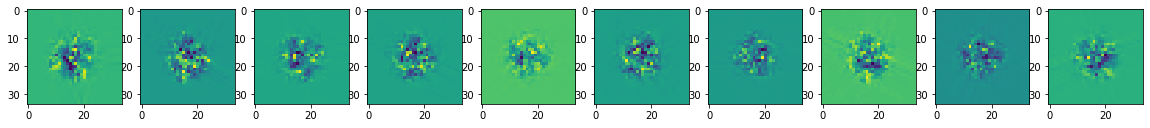

real


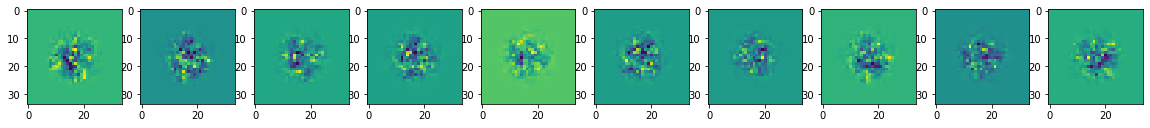

torch.mean(self.mu) tensor(0.1180)
torch.mean(self.BigSigma_I) tensor(0.0175)
monotor sigma j max tensor(3.8480)
generated


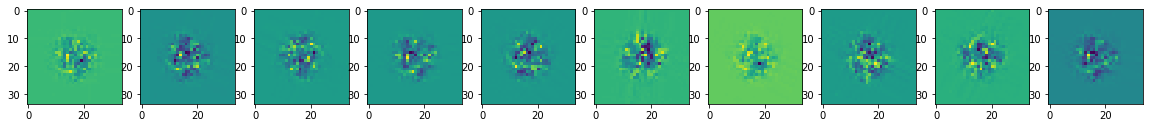

real


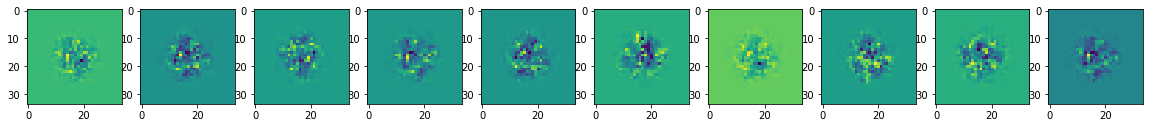

torch.mean(self.mu) tensor(0.1050)
torch.mean(self.BigSigma_I) tensor(0.0139)
monotor sigma j max tensor(3.8480)
generated


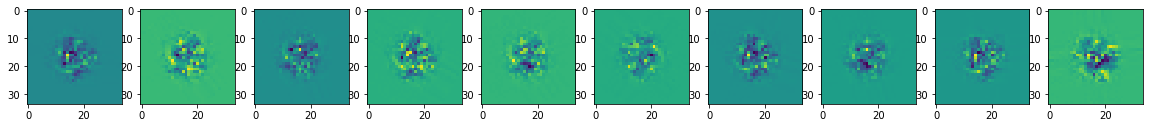

real


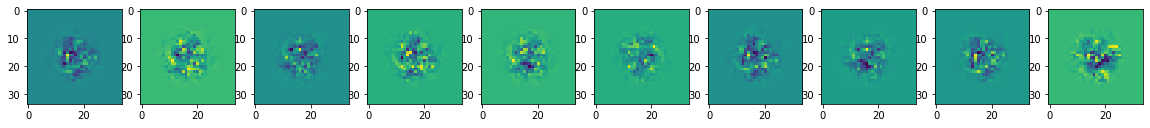

torch.mean(self.mu) tensor(0.1014)
torch.mean(self.BigSigma_I) tensor(0.0132)
monotor sigma j max tensor(3.8480)
generated


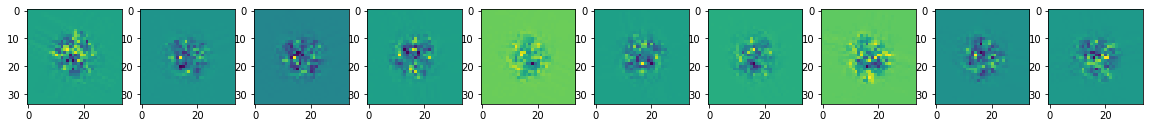

real


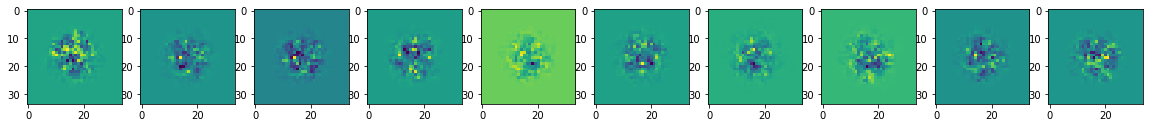

torch.mean(self.mu) tensor(0.1054)
torch.mean(self.BigSigma_I) tensor(0.0141)
monotor sigma j max tensor(3.8480)
generated


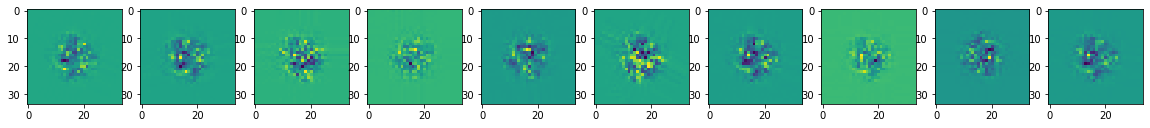

real


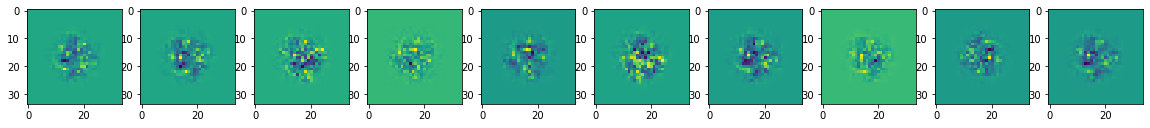

torch.mean(self.mu) tensor(0.0932)
torch.mean(self.BigSigma_I) tensor(0.0123)
monotor sigma j max tensor(3.8480)
generated


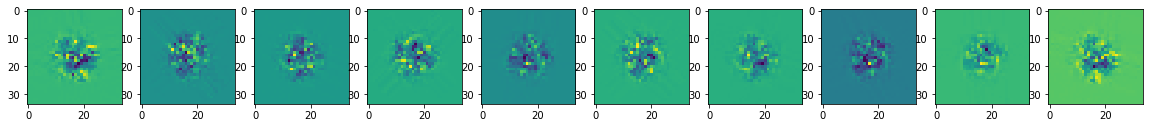

real


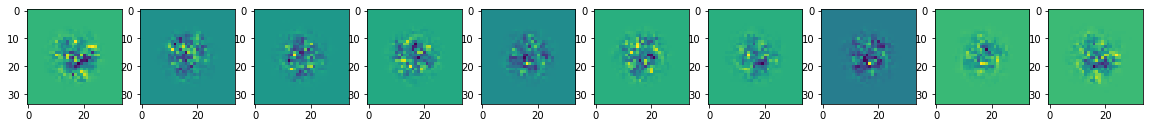

torch.mean(self.mu) tensor(0.1114)
torch.mean(self.BigSigma_I) tensor(0.0160)
monotor sigma j max tensor(3.8480)
generated


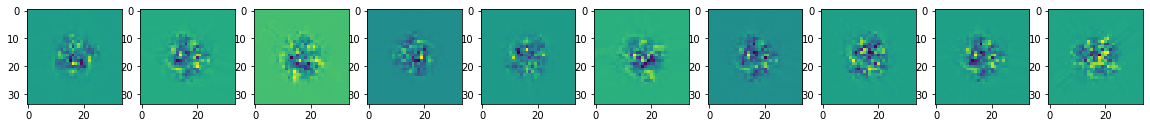

real


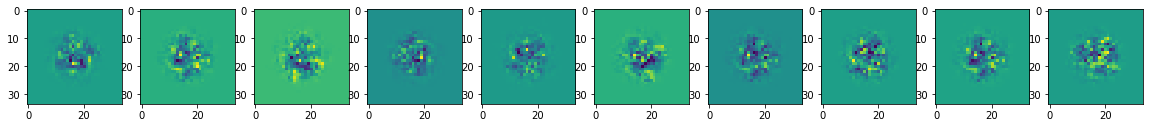

torch.mean(self.mu) tensor(0.1015)
torch.mean(self.BigSigma_I) tensor(0.0146)
monotor sigma j max tensor(3.8480)
generated


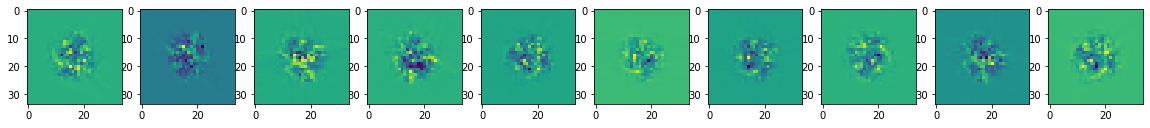

real


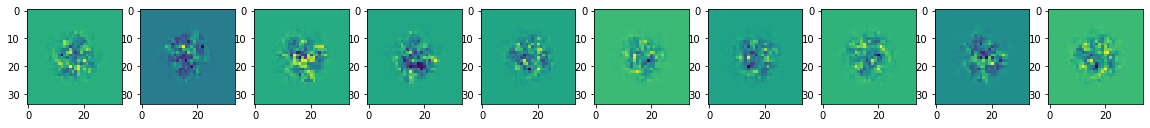

torch.mean(self.mu) tensor(0.1050)
torch.mean(self.BigSigma_I) tensor(0.0145)
monotor sigma j max tensor(3.8480)
generated


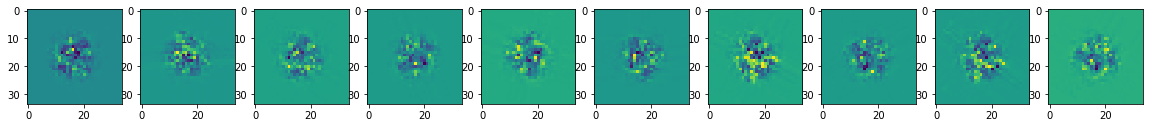

real


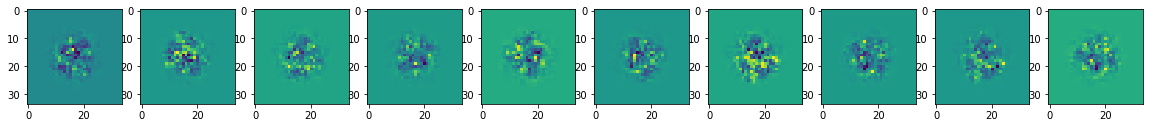

torch.mean(self.mu) tensor(0.1003)
torch.mean(self.BigSigma_I) tensor(0.0136)
monotor sigma j max tensor(3.8480)
generated


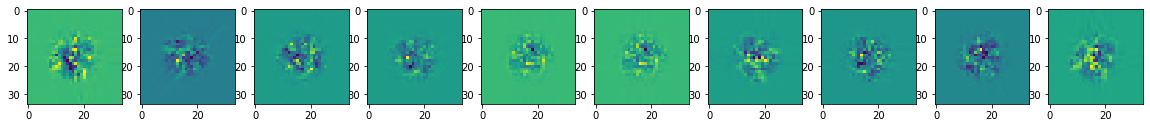

real


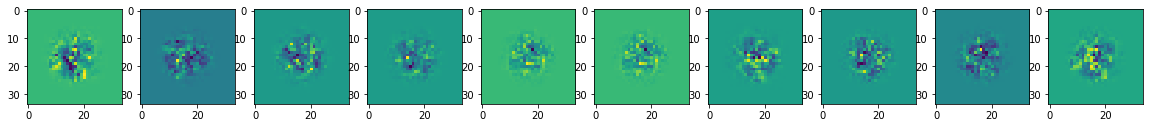

torch.mean(self.mu) tensor(0.1038)
torch.mean(self.BigSigma_I) tensor(0.0134)
monotor sigma j max tensor(3.8480)
generated


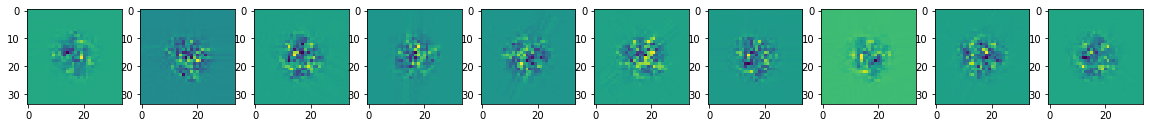

real


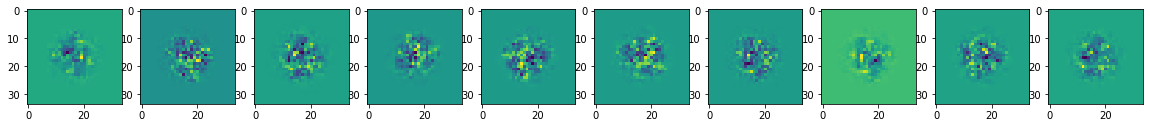

torch.mean(self.mu) tensor(0.1133)
torch.mean(self.BigSigma_I) tensor(0.0154)
monotor sigma j max tensor(3.8480)
generated


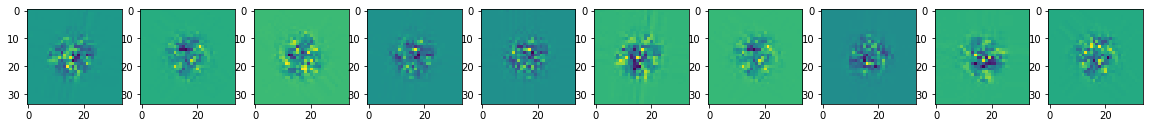

real


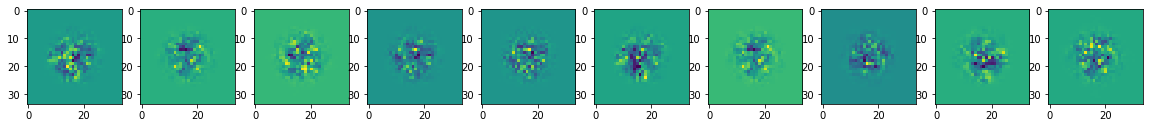

torch.mean(self.mu) tensor(0.0966)
torch.mean(self.BigSigma_I) tensor(0.0125)
monotor sigma j max tensor(3.8480)
generated


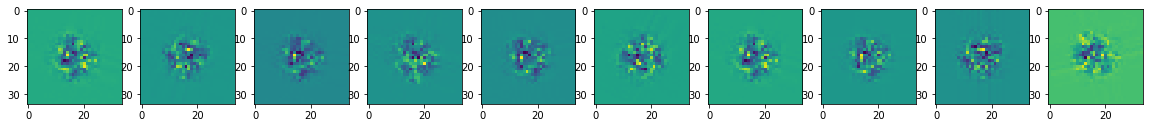

real


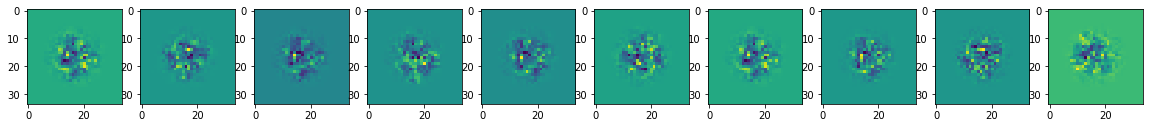

torch.mean(self.mu) tensor(0.0953)
torch.mean(self.BigSigma_I) tensor(0.0134)
monotor sigma j max tensor(3.8480)
generated


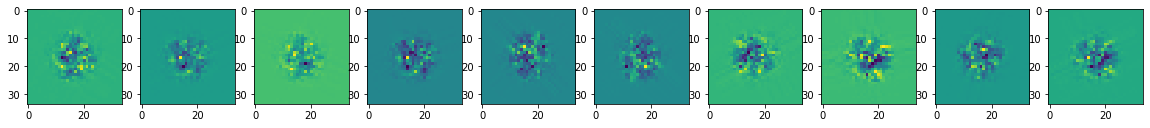

real


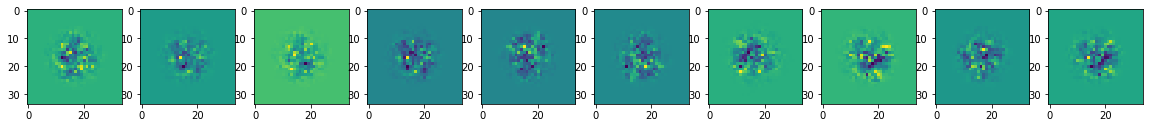

torch.mean(self.mu) tensor(0.0879)
torch.mean(self.BigSigma_I) tensor(0.0115)
monotor sigma j max tensor(3.8480)
generated


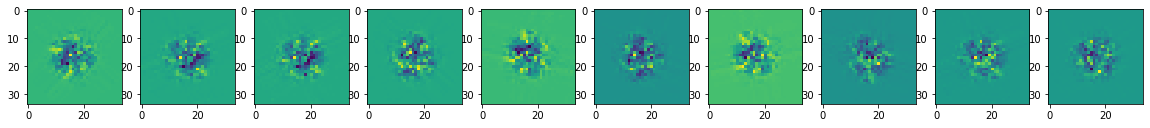

real


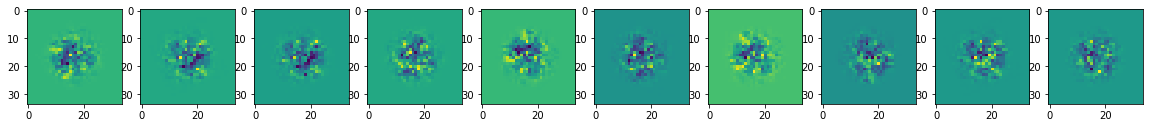

torch.mean(self.mu) tensor(0.1084)
torch.mean(self.BigSigma_I) tensor(0.0150)
monotor sigma j max tensor(3.8480)
generated


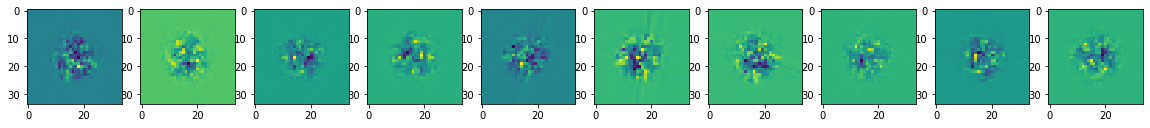

real


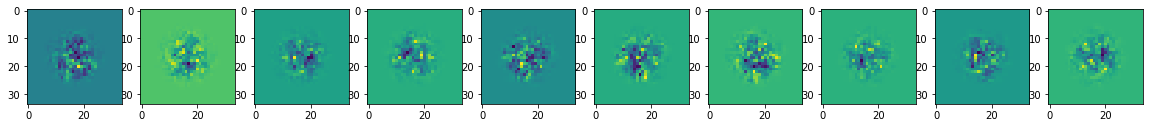

torch.mean(self.mu) tensor(0.0977)
torch.mean(self.BigSigma_I) tensor(0.0136)
monotor sigma j max tensor(3.8480)
generated


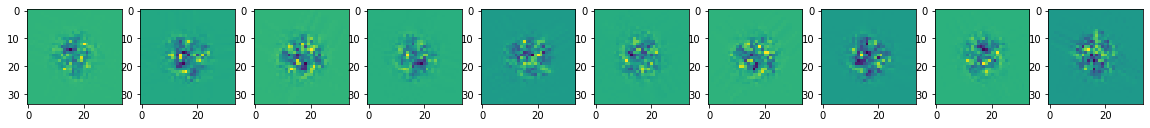

real


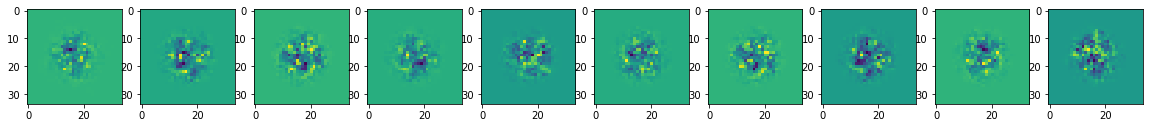

torch.mean(self.mu) tensor(0.0921)
torch.mean(self.BigSigma_I) tensor(0.0126)
monotor sigma j max tensor(3.8480)
generated


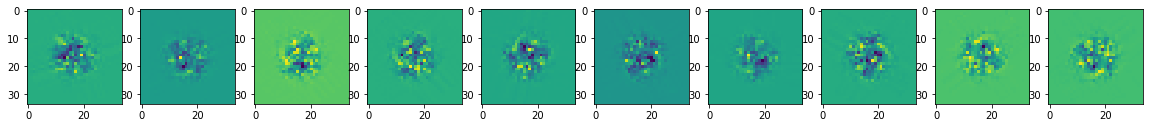

real


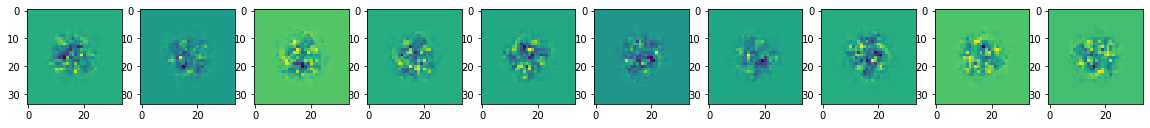

torch.mean(self.mu) tensor(0.1151)
torch.mean(self.BigSigma_I) tensor(0.0173)
monotor sigma j max tensor(3.8480)
generated


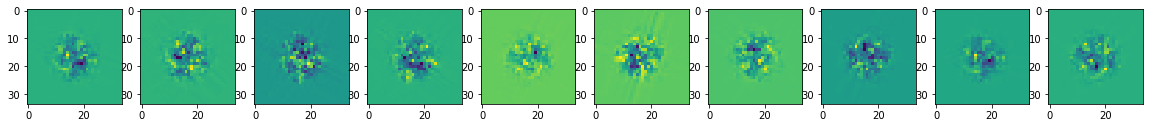

real


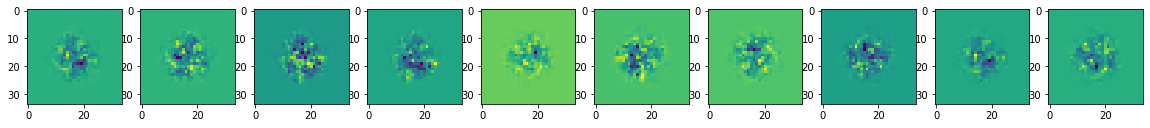

torch.mean(self.mu) tensor(0.1000)
torch.mean(self.BigSigma_I) tensor(0.0130)
monotor sigma j max tensor(3.8480)
generated


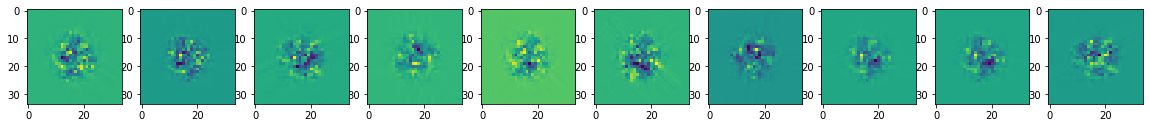

real


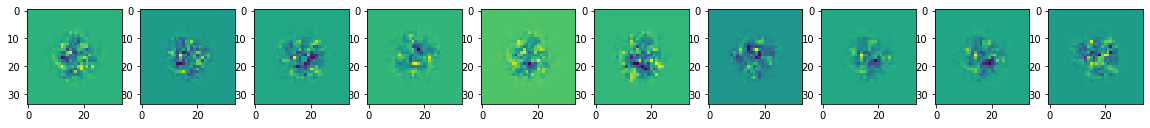

torch.mean(self.mu) tensor(0.0948)
torch.mean(self.BigSigma_I) tensor(0.0129)
monotor sigma j max tensor(3.8480)
generated


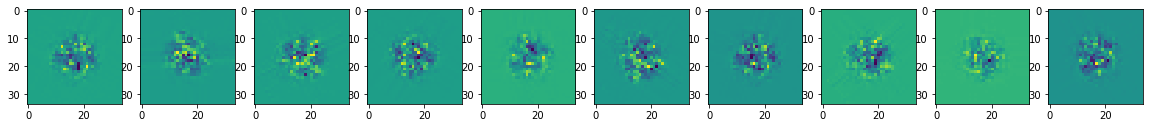

real


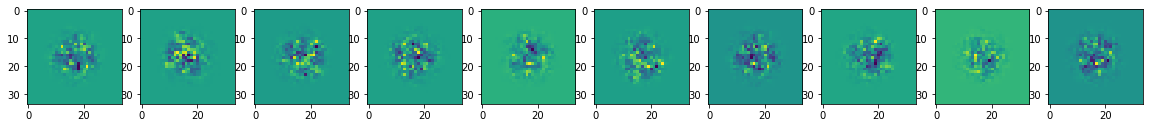

torch.mean(self.mu) tensor(0.1033)
torch.mean(self.BigSigma_I) tensor(0.0135)
monotor sigma j max tensor(3.8480)
generated


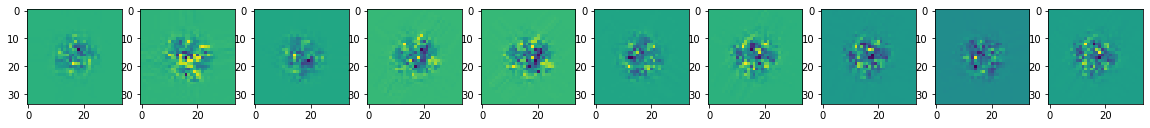

real


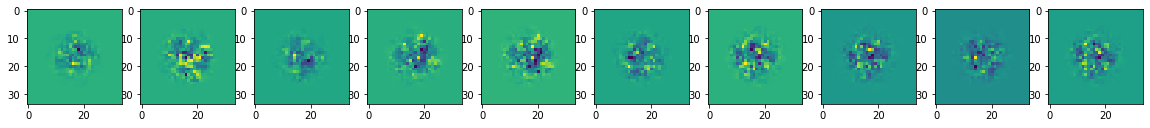

torch.mean(self.mu) tensor(0.1041)
torch.mean(self.BigSigma_I) tensor(0.0137)
monotor sigma j max tensor(3.8480)
generated


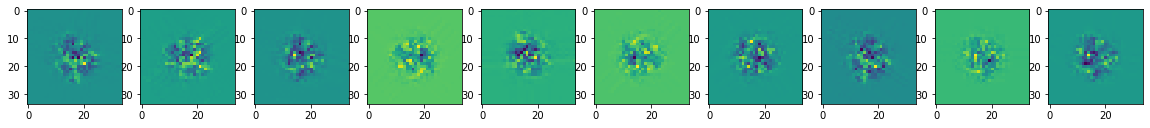

real


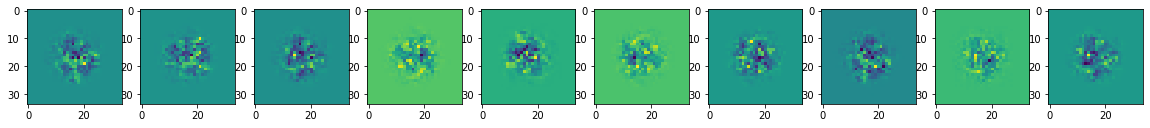

torch.mean(self.mu) tensor(0.0958)
torch.mean(self.BigSigma_I) tensor(0.0131)
monotor sigma j max tensor(3.8480)
generated


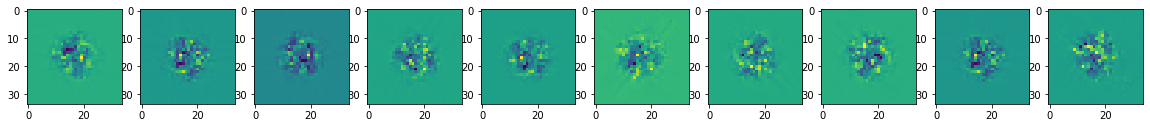

real


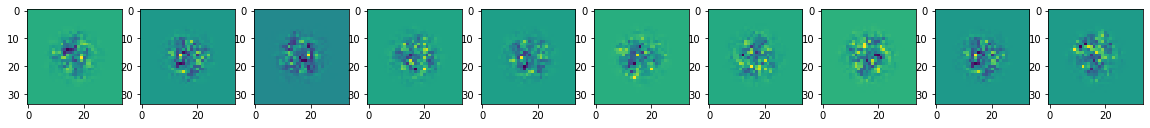

torch.mean(self.mu) tensor(0.0976)
torch.mean(self.BigSigma_I) tensor(0.0128)
monotor sigma j max tensor(3.8480)
generated


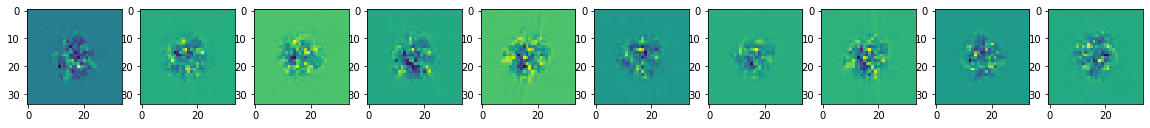

real


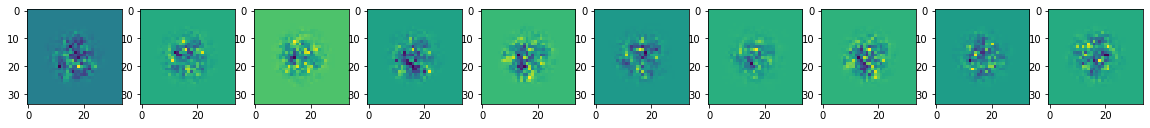

torch.mean(self.mu) tensor(0.1118)
torch.mean(self.BigSigma_I) tensor(0.0157)
monotor sigma j max tensor(3.8480)
generated


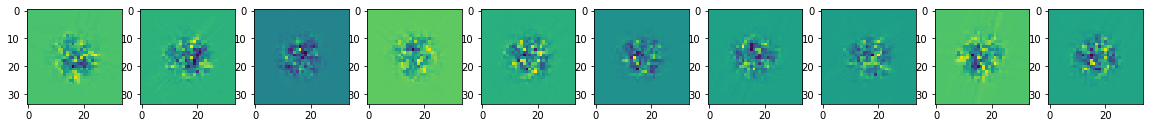

real


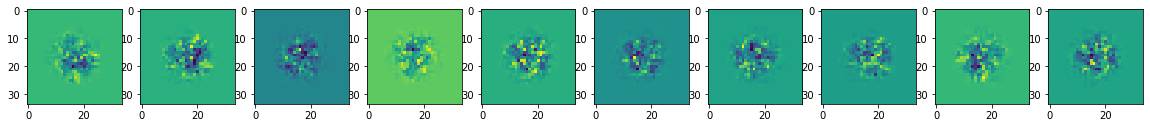

torch.mean(self.mu) tensor(0.0998)
torch.mean(self.BigSigma_I) tensor(0.0136)
monotor sigma j max tensor(3.8480)
generated


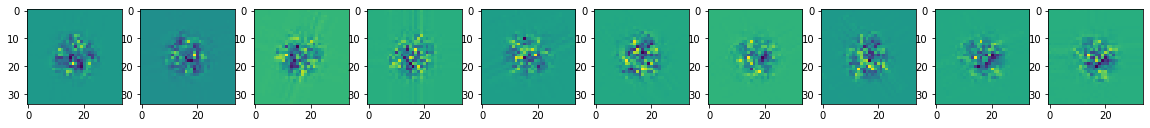

real


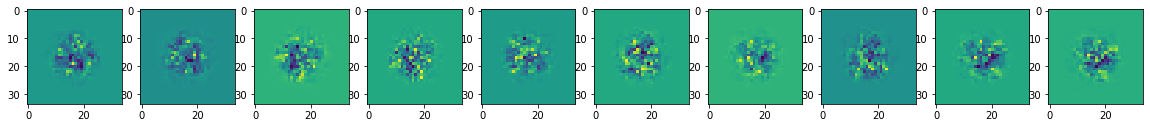

torch.mean(self.mu) tensor(0.1000)
torch.mean(self.BigSigma_I) tensor(0.0136)
monotor sigma j max tensor(3.8480)
generated


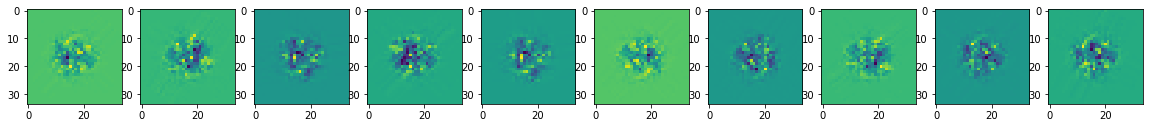

real


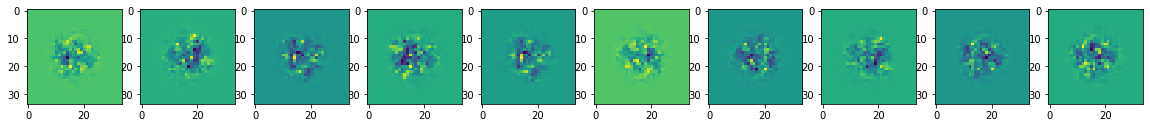

(9200, 10648, 1)


In [22]:
MP3.Output_colection()
Coef = np.array(MP3.All_mu)
#Then perform PCA of T-SNE on allMu
print(Coef.shape)

In [23]:

tsne = TSNE(n_components=2, verbose=1, random_state=123)

"""
x = Coef.reshape(5000, -1)
z = tsne.fit_transform(x) 
"""


'\nx = Coef.reshape(5000, -1)\nz = tsne.fit_transform(x) \n'

In [24]:
import numpy as np
"""
np.random.seed(0)

indexs = np.random.randint(5, size = 5000)
print(indexs[:10])
df = pd.DataFrame()
df["y"] = indexs
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 5),
                data=df).set(title="5Ribsome data true label") 

"""


'\nnp.random.seed(0)\n\nindexs = np.random.randint(5, size = 5000)\nprint(indexs[:10])\ndf = pd.DataFrame()\ndf["y"] = indexs\ndf["comp-1"] = z[:,0]\ndf["comp-2"] = z[:,1]\n\nsns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),\n                palette=sns.color_palette("hls", 5),\n                data=df).set(title="5Ribsome data true label") \n\n'

In [31]:
print(Coef.shape)
Coef = Coef.reshape(9200, -1)
pca = PCA(n_components=5)
pca.fit(Coef)
P_Coef = pca.transform(Coef)
print(P_Coef.shape)

(9200, 10648)
(9200, 5)


In [32]:
z = tsne.fit_transform(P_Coef) 
import numpy as np
np.random.seed(0)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9200 samples in 0.008s...
[t-SNE] Computed neighbors for 9200 samples in 0.648s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9200
[t-SNE] Computed conditional probabilities for sample 2000 / 9200
[t-SNE] Computed conditional probabilities for sample 3000 / 9200
[t-SNE] Computed conditional probabilities for sample 4000 / 9200
[t-SNE] Computed conditional probabilities for sample 5000 / 9200
[t-SNE] Computed conditional probabilities for sample 6000 / 9200
[t-SNE] Computed conditional probabilities for sample 7000 / 9200
[t-SNE] Computed conditional probabilities for sample 8000 / 9200
[t-SNE] Computed conditional probabilities for sample 9000 / 9200
[t-SNE] Computed conditional probabilities for sample 9200 / 9200
[t-SNE] Mean sigma: 11.447841
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.007538
[t-SNE] KL divergence after 1000 iterations: 0.954898


(9200, 2)
[3, 0, 2, 0, 2, 2, 0, 2, 4, 3]


[Text(0.5, 1.0, '5Ribsome data true label')]

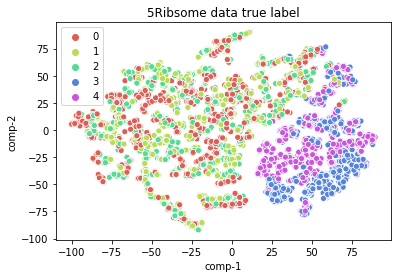

In [33]:
print(z.shape)
#print(len(indexs))

indexs = Index_3DVA[:9200]
print(indexs[:10])
df = pd.DataFrame()
df["y"] = indexs
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 5),
                data=df).set(title="5Ribsome data true label") 


[Text(0.5, 1.0, '5Ribsome data k-mean')]

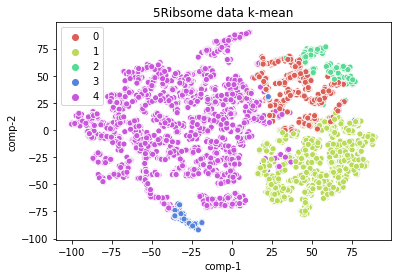

In [34]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(P_Coef) #k-mean perform on PCA coef
kmeans.labels_

df = pd.DataFrame()
df["y"] = kmeans.labels_
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 5),
                data=df).set(title="5Ribsome data k-mean") 

In [35]:

print(v_measure_score(indexs, kmeans.labels_))

0.3455054092305929
